In [71]:
EMULATORS_PATH = "/Users/gabe/projects/emulators/src"
RECOMBINATION_PATH = "/Users/gabe/projects/recombination/src"
PLANCK_LITE_PATH = "/Users/gabe/projects/planck/planck-lite-py"

import sys
import os
import numpy as np
from scipy.interpolate import CubicSpline
import scipy
import classy as Class


import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr
from mpl_toolkits.axes_grid1 import make_axes_locatable

if EMULATORS_PATH not in sys.path:
    sys.path.insert(0, "/Users/gabe/projects/emulators/src")
if RECOMBINATION_PATH not in sys.path:
    sys.path.insert(0, "/Users/gabe/projects/recombination/src")
if PLANCK_LITE_PATH not in sys.path:
    sys.path.insert(0, PLANCK_LITE_PATH)
from TrainedEmulator import *
from RecTools import *
from ChainTools import *
from planck_lite_py import PlanckLitePy

from getdist import plots, MCSamples, loadMCSamples

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
mpl.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True

default_settings = plots.GetDistPlotSettings()
default_settings.axes_labelsize = 12
default_settings.fig_width_inch = 6
default_settings.linewidth = 2
default_settings.title_limit = 0
default_settings.legend_fontsize = 12

######################################################
#  Loading Chains
######################################################

#chains_to_load = ["modrec_prec", "modrec_prec_lensing", "lcdm_prec_lensing", "modrec_prec_lensing_bao", "lcdm_prec_lensing_bao"]
chains_to_load = ["modrec_new", "modrec_new_lensing", "modrec_new_lensing_bao", "modrec_new_lensing_bao_shoes", "lcdm_lensing_bao"]

chains = {}

burnin_dict = {"modrec_new": 0.5,
               "modrec_new_lensing": 0.5,
               "modrec_new_lensing_bao": 0.6,
               "modrec_new_lensing_underdisperse": 0.05,
               "modrec_new_lensing_bao_shoes": 0.5,
               "lcdm_lensing_bao": 0.05}

chain_dirname = "/Users/gabe/projects/recombination/data/chains/"

for chain in chains_to_load:
    dirname = os.path.join(chain_dirname, "{}/chains".format(chain))
    s = loadMCSamples(os.path.join(dirname, chain), settings={"ignore_rows": burnin_dict[chain], "fine_bins": 2048})

    chains[chain] = s

chi2_lensing_bao_lcdm_bestfit = chains["lcdm_lensing_bao"].getParamBestFitDict()["chi2__CMB"] + chains["lcdm_lensing_bao"].getParamBestFitDict()["chi2__BAO"]

s_planck = loadMCSamples(os.path.join(chain_dirname, "planck_baseline/base_plikHM_TTTEEE_lowl_lowE_lensing"))

planck_renames = {'omegabh2': 'omega_b',
                  'omegach2': 'omega_cdm', 
                  'tau': 'tau_reio', 
                  'ns': 'n_s',
                  'rdrag': 'rs_d'}
s_planck.updateRenames(planck_renames)
chains["planck_baseline"] = s_planck
planck_bestfit = chains["planck_baseline"].getParamBestFitDict()

s_class = loadMCSamples(os.path.join(chain_dirname, "modrec_new_class/chains/modrec_new.post.CLASS"))
chains["modrec_new_class"] = s_class

s_class = loadMCSamples(os.path.join(chain_dirname, "modrec_new_lensing_bao_shoes_class/chains/modrec_new_lensing_bao_shoes.post.CLASS"))
chains["modrec_new_lensing_bao_shoes_class"] = s_class
######################################################
#  Loading Emulator
######################################################

emulator_dir = "/Users/gabe/projects/emulators/models"
emulator_name = "modrec_new_18"

em = TrainedEmulator(os.path.join(emulator_dir, emulator_name))

In [11]:
best_fit_params = {"omega_b": planck_bestfit["omegabh2"],
             "omega_cdm": planck_bestfit["omegach2"],
             "tau_reio": planck_bestfit["tau"],
             "ln10^{10}A_s": planck_bestfit["logA"],
             "n_s": planck_bestfit["ns"],
             "H0": planck_bestfit["H0"],
             "q_1": 0.0,
             "q_2": 0.0,
             "q_3": 0.0,
             "q_4": 0.0,
             "q_5": 0.0}

mg_planck = chains["planck_baseline"].getMargeStats()

mean_params = {"omega_b": mg_planck.parWithName("omega_b").mean,
             "omega_cdm": mg_planck.parWithName("omega_cdm").mean,
             "tau_reio": mg_planck.parWithName("tau_reio").mean,
             "ln10^{10}A_s": mg_planck.parWithName("logA").mean,
             "n_s": mg_planck.parWithName("n_s").mean,
             "H0": mg_planck.parWithName("H0").mean,
             "q_1": 0.0,
             "q_2": 0.0,
             "q_3": 0.0,
             "q_4": 0.0,
             "q_5": 0.0}

print(best_fit_params)
planck_predictions_bestfit = em.get_predictions_dict(best_fit_params)
planck_predictions_mean = em.get_predictions_dict(mean_params)

{'omega_b': 0.0223828, 'omega_cdm': 0.1201075, 'tau_reio': 0.05430842, 'ln10^{10}A_s': 3.044784, 'n_s': 0.9660499, 'H0': 67.32117, 'q_1': 0.0, 'q_2': 0.0, 'q_3': 0.0, 'q_4': 0.0, 'q_5': 0.0}


Text(0.65, 0.78, 'Riess 2020')

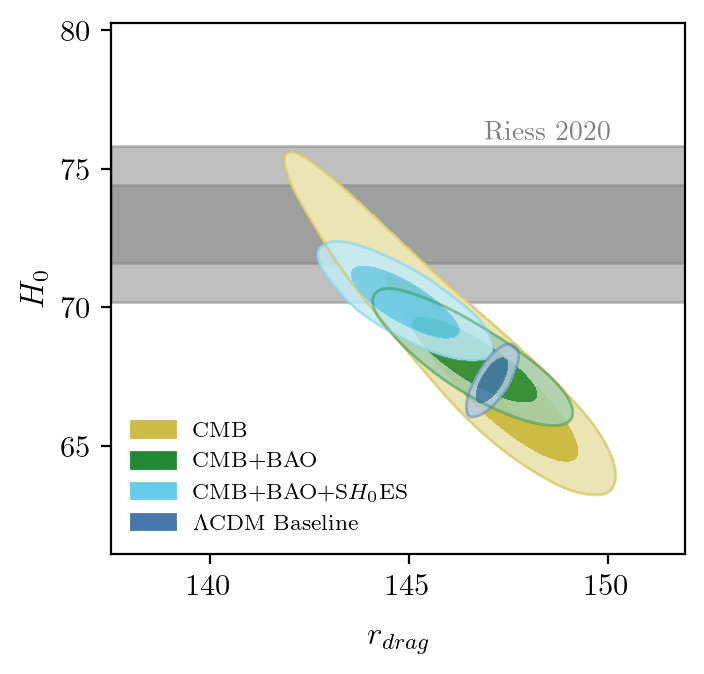

In [4]:
g = plots.get_single_plotter()
g.settings = default_settings
g.settings.fig_width_inch = 1

vibrant_colors = ["#0077BB", "#009988", "#EE7733", "#CC3311"]

g.settings.solid_colors = ['#4477AA', '#66CCEE', '#228833', '#CCBB44']

labels = ["CMB", "CMB+BAO",  "CMB+BAO+S$H_0$ES", "$\Lambda$CDM Baseline"]


params_to_plot = ['omega_b', 'omega_cdm', 'H0', 'rs_star', 'rs_d']
#params_to_plot = ['rs_star', 'rs_d']

ax = g.get_axes()
fig = ax.get_figure()

ax.axhspan(73-2*1.4, 73+2*1.4, color="gray", alpha=0.5)
ax.axhspan(73-1*1.4, 73+1*1.4, color="gray", alpha=0.5)

#g.triangle_plot([chains["modrec_new_lensing"], chains["modrec_new_lensing_bao"], chains["modrec_new_lensing_bao_shoes"], chains["planck_baseline"]], legend_labels=labels, params=params_to_plot, filled=True)
g.plot_2d([chains["modrec_new_lensing"], chains["modrec_new_lensing_bao"], chains["modrec_new_lensing_bao_shoes"], chains["planck_baseline"]], "rs_d", "H0", filled=True)
#g.plot_2d([chains["modrec_new_lensing_bao_shoes"]], "rs_d", "H0", filled=True)

g.add_legend(legend_labels=labels, legend_loc='lower left', fontsize=8)

ax.get_legend().get_frame().set_linewidth(0.0)
fig.set_size_inches(w=3.4, h=3.4)
ax.text(0.65,0.78,s="Riess 2020",transform=ax.transAxes, color="gray", fontsize=10)

## Single density plot

In [5]:
chain_name = "modrec_new_lensing_bao"
total_predictions, total_models = get_predictions_for_selection(chains[chain_name], em, criteria='none')

y_range_dict = {"x_e": [0, 1.1],
                "g": [0, 0.025]}

chain_labels = {"modrec_new": "Primary CMB",
                "modrec_new_lensing": "CMB",
                "modrec_new_lensing_bao": "CMB+BAO",
                "modrec_new_lensing_shoes": "CMB+S$H_0$ES",
                "modrec_new_lensing_bao_shoes": "CMB+BAO+S$H_0$ES"}

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 10,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [8]:
quantity = "x_e"
y_range = y_range_dict[quantity]

#selection_criteria = {"H0": [71, 72]}
selection_criteria = 'none'

selection_predictions, selection_models = get_selection_from_predictions(chains[chain_name], total_predictions, criteria=selection_criteria)
trajectories, fine_grid = extract_trajectories_from_predictions(selection_predictions, em, quantity)

h, bins = construct_trajectory_heatmap(trajectories, y_range=y_range, num_bins=1000)

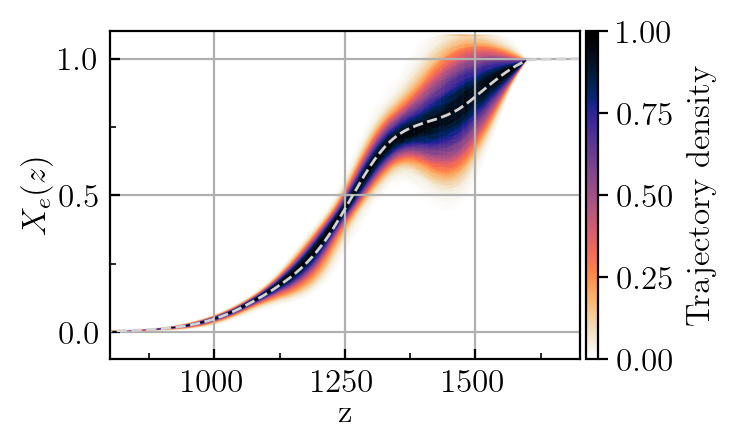

In [9]:
fig,ax = plt.subplots() 
fig.set_size_inches(w=3.03, h=2.13)


m=ax.imshow(h, cmap=mpl.cm.get_cmap('cmr.torch_r'), origin="lower", extent=[np.min(fine_grid), np.max(fine_grid), np.min(bins),np.max(bins)], aspect="auto")
ax.plot(fine_grid,np.mean(trajectories, axis=0), color="lightgray", linewidth=1, linestyle="dashed")
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
#ax.plot(fine_grid, CubicSpline(em.output_info["output_z_grids"]["x_e"], planck_prediction["x_e"][0])(fine_grid), linestyle="dashed", linewidth=2, color="blue")

#ax.text(0.06, 0.8, "{} constraints".format(chain_labels[chain_name]), transform=ax.transAxes)
   
ax.set_xlim([800, 1700])
ax.set_ylim([-0.1, 1.1])


ax.tick_params(axis = 'x', which = 'major', direction="in", labelsize = 12)
ax.tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)
ax.tick_params(axis = 'y', which = 'major', direction="in", labelsize = 12)
ax.tick_params(axis = 'y', which = 'minor', direction="in", labelsize = 0)

ax.set_xticks([875, 1125, 1375, 1625], minor=True)
ax.set_yticks([.25, .75], minor=True)

ax.set_xlabel("z", fontsize=12, labelpad=0)
ax.set_ylabel("$X_e(z)$", fontsize=12, labelpad=2)
ax.grid(True)
#ax.set_title(chain_name)
#ax.set_title("${:.2f} < {} < {:.2f}$".format(selection_criteria["H0"][0], "H_0", selection_criteria["H0"][1]))
cb = plt.colorbar(m, cax=cax)
cb.set_label(label="Trajectory density",size=12)
cb.ax.tick_params(labelsize=12)
#plt.savefig('../results/xe_distribution_cmbonly.pdf', dpi=300,bbox_inches='tight', pad_inches=0.0)

## Animate

In [10]:
planck_cosmo = {"omega_b": [planck_bestfit["omegabh2"]],
                "omega_cdm": [planck_bestfit["omegach2"]],
                "tau_reio": [planck_bestfit["tau"]], 
                "ln10^{10}A_s": [planck_bestfit["logA"]],
                "n_s": [planck_bestfit["ns"]],
                "H0": [planck_bestfit["H0"]], 
                "q_1": [0],
                "q_2": [0],
                "q_3": [0],
                "q_4": [0],
                "q_5": [0]}
planck_prediction = em.get_predictions_dict(planck_cosmo)

In [30]:
chain_name = "modrec_new_lensing_bao"
total_predictions, total_models = get_predictions_for_selection(chains[chain_name], em, criteria='none')
cut_parameter = "H0"
quantity = "x_e"

chain_as_dict = chains[chain_name].getParams().__dict__
histo, be = np.histogram(chain_as_dict[cut_parameter], bins=60)

bands = be[np.where(histo>1000)]
bands = [[bands[i], bands[i+1]] for i in np.arange(len(bands)-1)]

heatmaps = []
trajectories_list = []
y_bins = []
for band in bands: 
    selection_criteria = {cut_parameter: band}

    selection_predictions, selection_models = get_selection_from_predictions(chains[chain_name], total_predictions, criteria=selection_criteria)
    trajectories, fine_grid = extract_trajectories_from_predictions(selection_predictions, em, quantity)

    h, bins = construct_trajectory_heatmap(trajectories, y_range=y_range_dict[quantity], num_bins=1000)
    heatmaps.append(h)
    trajectories_list.append(trajectories)
    y_bins=bins

(chain_as_dict["H0"] > 65.38922881666667) & (chain_as_dict["H0"] < 65.5574738)
(chain_as_dict["H0"] > 65.5574738) & (chain_as_dict["H0"] < 65.72571878333333)
(chain_as_dict["H0"] > 65.72571878333333) & (chain_as_dict["H0"] < 65.89396376666667)
(chain_as_dict["H0"] > 65.89396376666667) & (chain_as_dict["H0"] < 66.06220875)
(chain_as_dict["H0"] > 66.06220875) & (chain_as_dict["H0"] < 66.23045373333333)
(chain_as_dict["H0"] > 66.23045373333333) & (chain_as_dict["H0"] < 66.39869871666667)
(chain_as_dict["H0"] > 66.39869871666667) & (chain_as_dict["H0"] < 66.5669437)
(chain_as_dict["H0"] > 66.5669437) & (chain_as_dict["H0"] < 66.73518868333333)
(chain_as_dict["H0"] > 66.73518868333333) & (chain_as_dict["H0"] < 66.90343366666667)
(chain_as_dict["H0"] > 66.90343366666667) & (chain_as_dict["H0"] < 67.07167865)
(chain_as_dict["H0"] > 67.07167865) & (chain_as_dict["H0"] < 67.23992363333333)
(chain_as_dict["H0"] > 67.23992363333333) & (chain_as_dict["H0"] < 67.40816861666667)
(chain_as_dict["H0"]

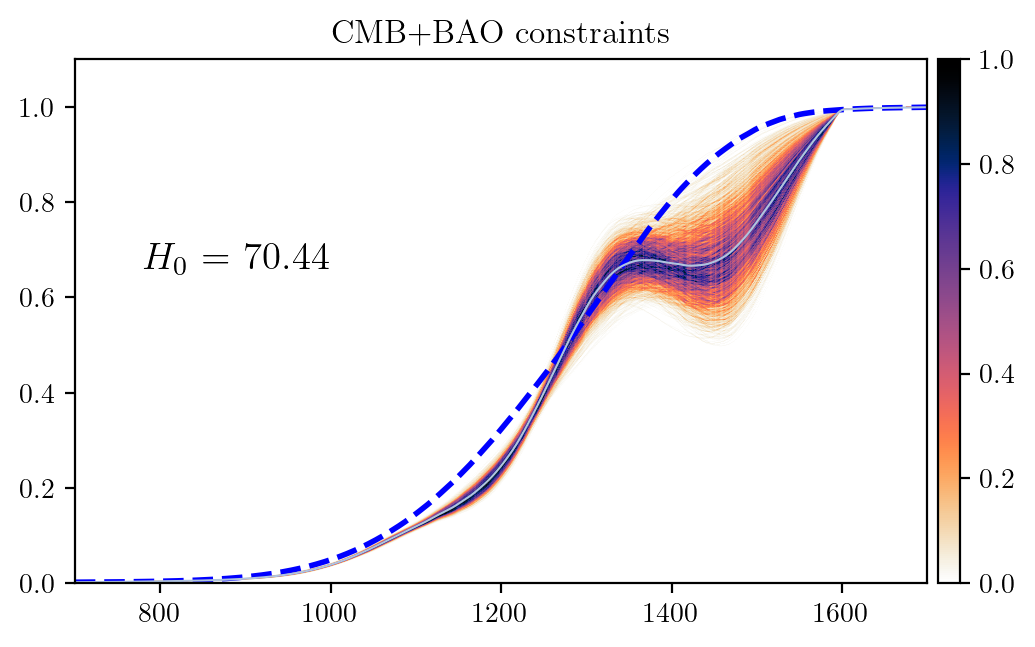

In [37]:
%matplotlib inline
from matplotlib import animation


fig  = plt.figure()
fig.set_size_inches(w=5.5, h=3.4)
ax = plt.subplot()
ax.set_ylim(y_range_dict[quantity])
ax.set_title("{} constraints".format(chain_labels[chain_name]))
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

im=ax.imshow(heatmaps[0],cmap=mpl.cm.get_cmap('cmr.torch_r'), origin="lower", extent=[np.min(fine_grid), np.max(fine_grid), np.min(bins),np.max(bins)], aspect="auto")
plt.colorbar(m, cax=cax)

line, = ax.plot(fine_grid, np.mean(trajectories_list[0], axis=0), color="lightsteelblue", linewidth=0.75)
label_text = ax.text(0.08, 0.6, '', transform=ax.transAxes, fontsize=14)

h, be = np.histogram(chain_as_dict[cut_parameter], bins=60)
band_labels = be[np.where(h>1000)]

label_dict = {"z_star": "z_\star",
              "H0": "H_0"}

def init():
    im.set_data(heatmaps[0])
    line.set_data(fine_grid, np.mean(trajectories_list[0], axis=0))
    label_text.set_text("${}$ = {:.2f}".format(label_dict[cut_parameter], band_labels[0]))
    return im,line,label_text

# animation function.  This is called sequentially
def animate(i):
    im.set_array(heatmaps[i])
    line.set_data(fine_grid, np.mean(trajectories_list[i], axis=0))
    label_text.set_text("${}$ = {:.2f}".format(label_dict[cut_parameter], band_labels[i]))
    return im,line,label_text

fps = 10
nSeconds = (len(bands)-1)/fps
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(bands)-1, interval=1000/fps, blit=True)

anim.save('xe_distributions_H0_cut_cmb_bao.gif',writer="ffmpeg",dpi=300)

In [19]:
def extract_fractional_trajectories(predictions, predicted_models, emulator, fid_xe=None, n=1000):

    pivot_grid = em.output_info["output_z_grids"]["x_e"]

    if fid_xe is None:
        standard_rec_models = predicted_models.copy()
        extension_params = ["q_1", "q_2", "q_3", "q_4", "q_5"]

        for q in extension_params:
            standard_rec_models[q] = np.zeros(standard_rec_models["H0"].shape)

        standard_rec_predictions = emulator.get_predictions_dict(standard_rec_models)
        fid = standard_rec_predictions["x_e"]
    else:
        fid = fid_xe
    full_xe = predictions["x_e"]
    frac_pert = (full_xe - fid)/(fid)
    #frac_pert = (full_xe - fid)

    fine_grid = np.linspace(min(pivot_grid), max(pivot_grid), n)

    trajectories = np.vstack([CubicSpline(pivot_grid, y)(fine_grid) for y in frac_pert])

    return trajectories, fine_grid

In [65]:
chain_name = "modrec_new_lensing"
marge_stats = chains[chain_name].getMargeStats()
bestfit = chains[chain_name].getParamBestFitDict()
print(bestfit.keys())
mean_params = {}
for param in em.output_info["input_names"]:
    name = param
    if name=='ln10^{10}A_s':
        name = "logA"
    #mean_params[param] = np.array(marge_stats.parWithName(name).mean)
    mean_params[param] = np.array(bestfit[name])

print(mean_params)
mean_xe = em.get_predictions_dict(mean_params)["x_e"][0]
extension_params = ["q_1", "q_2", "q_3", "q_4", "q_5"]
standard_mean_params = mean_params.copy()
for q in extension_params:
    standard_mean_params[q] = np.zeros(mean_params["H0"].shape)

mean_standard_xe = em.get_predictions_dict(standard_mean_params)["x_e"][0]
mean_frac_pert = CubicSpline(em.output_info["output_z_grids"]["x_e"], (mean_xe - mean_standard_xe)/mean_standard_xe)
#mean_frac_pert = CubicSpline(em.output_info["output_z_grids"]["x_e"], (mean_xe - mean_standard_xe))

MCSamplesError: Best fit can only be included if loaded from file and file_root.minimum exists (cannot be calculated from samples)

In [66]:
total_predictions, total_models = get_predictions_for_selection(chains[chain_name], em, criteria='none')
y_range = [-.6, 0.6]
#total_predictions, total_models = get_selection_from_predictions(chains[chain_name], total_predictions, criteria='none')
trajectories, fine_grid = extract_fractional_trajectories(total_predictions, total_models, em) 
h, bins = construct_trajectory_heatmap(trajectories, y_range=y_range, num_bins=1000)

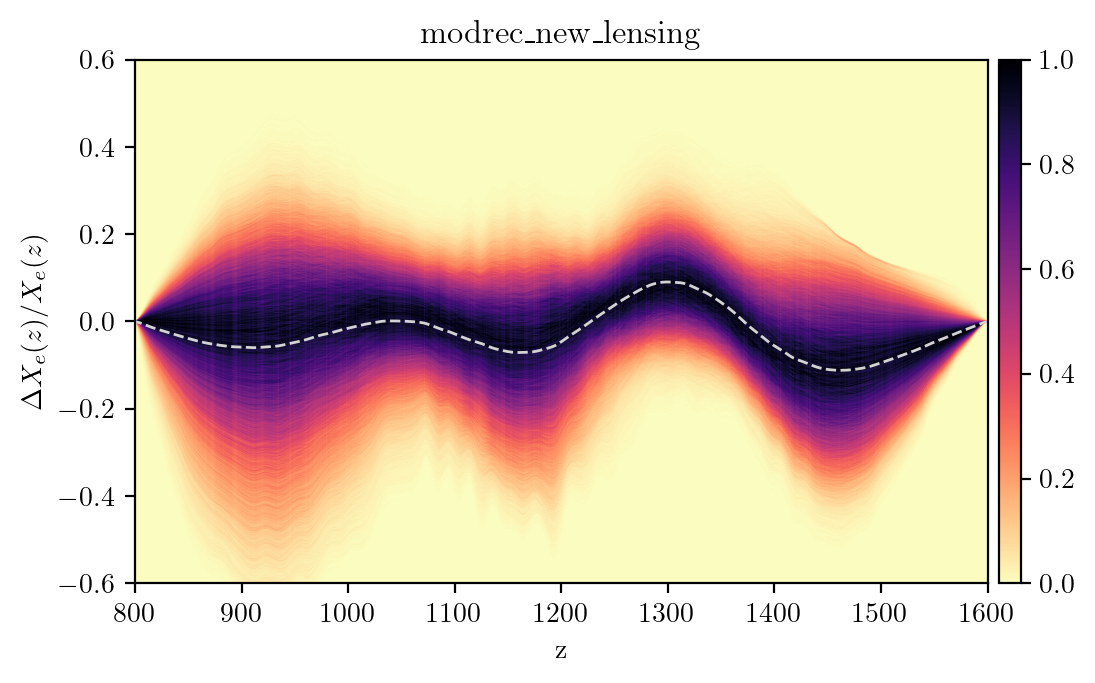

In [68]:
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 10,
    'text.usetex': True,
    'pgf.rcfonts': False,
})
fig,ax = plt.subplots() 
fig.set_size_inches(w=5.5, h=3.4)

m=ax.imshow(h, cmap=mpl.cm.get_cmap('magma_r'), origin="lower", extent=[np.min(fine_grid), np.max(fine_grid), np.min(bins),np.max(bins)], aspect="auto")
ax.plot(fine_grid,np.median(trajectories, axis=0), color="lightgray", linewidth=1, linestyle="dashed")
#ax.plot(fine_grid,mean_frac_pert(fine_grid), color="white", linewidth=1, linestyle="solid")
ax.set_title(chain_name)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
   
ax.set_xlabel("z")
ax.set_xlim([800, 1600])
#ax.set_ylabel("${}(z)$".format(quantity))
ax.set_ylabel("$\Delta X_e(z) / X_e(z)$")
#ax.set_title("${:.2f} < {} < {:.2f}$".format(selection_criteria["H0"][0], "H_0", selection_criteria["H0"][1]))
plt.colorbar(m, cax=cax)
#plt.savefig('../results/frac_xe_distribution_cmb_bao.pdf', dpi=300,bbox_inches='tight')

In [69]:
chain_name="modrec_new_lensing"
chain_as_dict = chains[chain_name].getParams().__dict__
cut_parameter = "H0"
h, be = np.histogram(chain_as_dict[cut_parameter], bins=60)
resolution = 1000
bands = be[np.where(h>1000)]
bands = [[bands[i], bands[i+1]] for i in np.arange(len(bands)-1)]
y_range = [-.6, 0.6]
heatmaps = []
trajectories_list = []
y_bins = []
for band in bands: 
    selection_criteria = {cut_parameter: band}

    selection_predictions, selection_models = get_selection_from_predictions(chains[chain_name], total_predictions, criteria=selection_criteria)
    trajectories, fine_grid = extract_fractional_trajectories(selection_predictions, selection_models, em, n=resolution)

    h, bins = construct_trajectory_heatmap(trajectories, y_range=y_range, num_bins=resolution)
    heatmaps.append(h)
    trajectories_list.append(trajectories)
    y_bins=bins

(chain_as_dict["H0"] > 63.325563700000004) & (chain_as_dict["H0"] < 63.6291118)
(chain_as_dict["H0"] > 63.6291118) & (chain_as_dict["H0"] < 63.9326599)
(chain_as_dict["H0"] > 63.9326599) & (chain_as_dict["H0"] < 64.236208)
(chain_as_dict["H0"] > 64.236208) & (chain_as_dict["H0"] < 64.5397561)
(chain_as_dict["H0"] > 64.5397561) & (chain_as_dict["H0"] < 64.8433042)
(chain_as_dict["H0"] > 64.8433042) & (chain_as_dict["H0"] < 65.1468523)
(chain_as_dict["H0"] > 65.1468523) & (chain_as_dict["H0"] < 65.4504004)
(chain_as_dict["H0"] > 65.4504004) & (chain_as_dict["H0"] < 65.7539485)
(chain_as_dict["H0"] > 65.7539485) & (chain_as_dict["H0"] < 66.0574966)
(chain_as_dict["H0"] > 66.0574966) & (chain_as_dict["H0"] < 66.3610447)
(chain_as_dict["H0"] > 66.3610447) & (chain_as_dict["H0"] < 66.6645928)
(chain_as_dict["H0"] > 66.6645928) & (chain_as_dict["H0"] < 66.9681409)
(chain_as_dict["H0"] > 66.9681409) & (chain_as_dict["H0"] < 67.271689)
(chain_as_dict["H0"] > 67.271689) & (chain_as_dict["H0"] < 

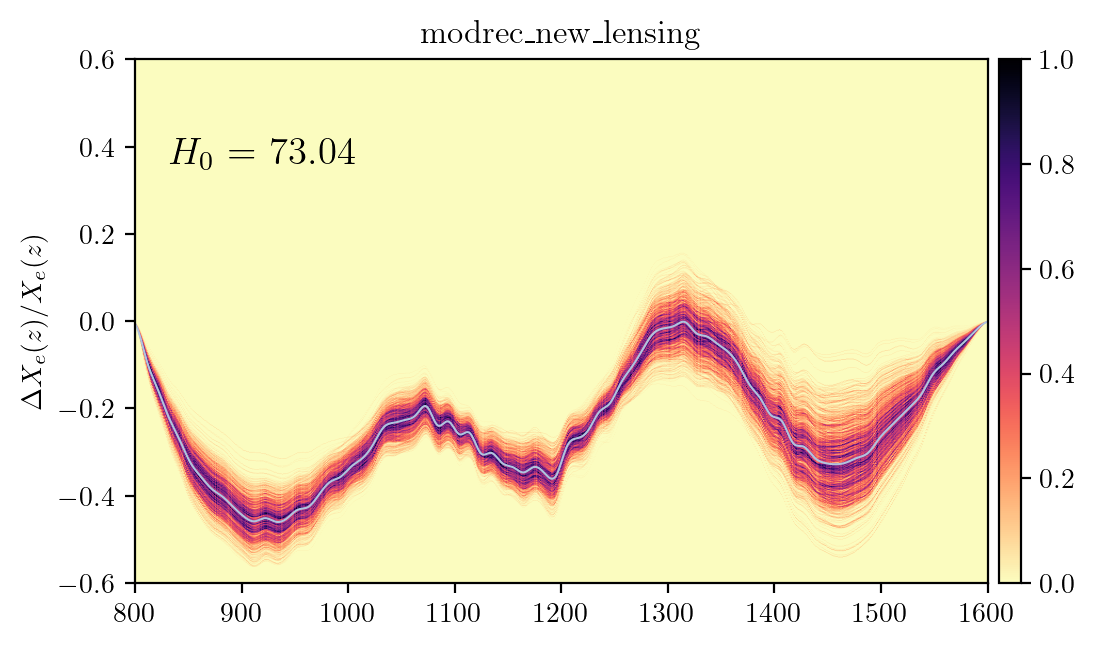

In [71]:
%matplotlib inline

from matplotlib import animation
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 10,
    'text.usetex': True,
    'pgf.rcfonts': False,
})
fig  = plt.figure( )
fig.set_size_inches(w=5.5, h=3.4)
ax = plt.subplot()
ax.set_ylim(y_range)
ax.set_xlim([800, 1600])
ax.set_ylabel("$\Delta X_e(z) / X_e(z)$")
ax.set_title(chain_name)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
a=np.zeros(shape=heatmaps[0].shape)
im=ax.imshow(heatmaps[0],cmap=mpl.cm.get_cmap('magma_r'), origin="lower", extent=[np.min(fine_grid), np.max(fine_grid), np.min(bins),np.max(bins)], aspect="auto")
plt.colorbar(m, cax=cax)
line, = ax.plot(fine_grid, np.mean(trajectories_list[0], axis=0), color="lightsteelblue", linewidth=0.75)
label_text = ax.text(0.04, 0.8, '', transform=ax.transAxes, fontsize=14)
h, be = np.histogram(chain_as_dict[cut_parameter], bins=60)
band_labels = be[np.where(h>1000)]

label_dict = {"z_star": "z_\star",
              "H0": "H_0"}

def init():
    im.set_data(heatmaps[0])
    line.set_data(fine_grid, np.mean(trajectories_list[0], axis=0))
    label_text.set_text("${}$ = {:.2f}".format(label_dict[cut_parameter], band_labels[0]))
    return im,line,label_text

# animation function.  This is called sequentially
def animate(i):
    im.set_array(heatmaps[i])
    line.set_data(fine_grid, np.mean(trajectories_list[i], axis=0))
    label_text.set_text("${}$ = {:.2f}".format(label_dict[cut_parameter], band_labels[i]))
    return im,line,label_text

fps = 10
nSeconds = (len(bands)-1)/fps
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(bands)-1, interval=1000/fps, blit=True)

anim.save('../results/gifs/frac_xe_distributions_H0_cut_cmb_new.gif',writer="ffmpeg",dpi=300)

## Checking error in likelihoods 

In [220]:
import pickle as pkl
spectra = ["tt", "te", "ee"]
ll_max = 2508
ell = np.arange(2, ll_max+1)
Tcmb = 2725500.0 # cmb temp in muK
muK2 = (Tcmb)**2

compute_new = False
#test_data_models, test_data_truth = em.get_training_data()
n=5000
chain_name = "modrec_new"
if compute_new:
    emulated_predictions, test_models = get_predictions_for_selection(chains[chain_name], em, criteria='random', N=n)
    with open("../data/chi2_test_models.pkl", "wb") as f:
         pkl.dump(test_models,f)
else:
    with open("../data/chi2_test_models.pkl", "rb") as f:
        test_models = pkl.load(f)
        emulated_predictions = em.get_predictions_dict(test_models)

In [221]:
if compute_new:
### Setting up class
    zmin_pert = 800
    zmax_pert = 1600
    num_free_control_points = 5

    pivots = np.linspace(zmin_pert, zmax_pert, 7)
    free_pivots = pivots[1:-1]
    pivots_str = ",".join(["{:.4f}".format(p) for p in pivots])

    precision_settings = {'N_ur': 2.0308,
                    'N_ncdm': 1,
                    'm_ncdm': 0.06,
                    'T_ncdm': 0.71611, #1 species of massive neutrinos
                    'lensing': 'yes',
                    'accurate_lensing': 1.0,
                    #'k_max_tau0_over_l_max': 15.00,
                    'perturbations_sampling_stepsize': 0.05,
                    'xe_pert_type': 'control',
                    'xe_pert_num': 7,
                    'xe_control_pivots': pivots_str,
                    'zmin_pert': zmin_pert,
                    'zmax_pert': zmax_pert,
                    'l_max_scalars': ll_max,
                    'start_sources_at_tau_c_over_tau_h': 0.004
                    }
    def create_cp_string(list_of_control_points):

        list_of_control_points = np.insert(list_of_control_points, 0, 0.0)
        list_of_control_points = np.append(list_of_control_points, 0.0)
        str_ctrl = ["{:.4f}".format(c) for c in list_of_control_points]
        str_ctrl = ",".join(str_ctrl)

        return str_ctrl

    M = Class.Class()
    M.set(precision_settings)

    test_truth = {}
    test_truth["ell"] = []
    test_truth["tt"] = []
    test_truth["te"] = []
    test_truth["ee"] = []
    for i in np.arange(len(test_models["H0"])):
        if(i%250==0):
            print(i)
        cosmo_settings = {'output' : 'tCl,pCl,lCl',
                    # LambdaCDM parameters
                    'H0':test_models["H0"][i],
                    'omega_b':test_models["omega_b"][i],
                    'omega_cdm':test_models["omega_cdm"][i],
                    'ln10^{10}A_s': test_models["ln10^{10}A_s"][i],
                    'n_s':test_models["n_s"][i],
                    'tau_reio': test_models["tau_reio"][i]
                    }
        cp_list = [test_models["q_{}".format(j)][i] for j in np.arange(1, len(free_pivots)+1)]
        cp_str = create_cp_string(cp_list)
        cosmo_settings.update({"xe_control_points":cp_str})
        M.set(cosmo_settings)
        try:
            M.compute()
            c_ell = M.lensed_cl(ll_max)
            ell = c_ell["ell"][2:]
            test_truth["ell"] = ell
            test_truth["tt"].append((ell*(ell+1)/(2*np.pi))*c_ell['tt'][2:])
            test_truth["te"].append((ell*(ell+1)/(2*np.pi))*c_ell['te'][2:])
            test_truth["ee"].append((ell*(ell+1)/(2*np.pi))*c_ell['ee'][2:])
        
        except Exception as e :
            print(e)
            continue
    with open("../data/chi2_test_spectra.pkl", "wb") as f:
        pkl.dump(test_truth,f)
else:
    with open("../data/chi2_test_spectra_truth.pkl", "rb") as f:
        test_truth = pkl.load(f)

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750


In [222]:
print(len(test_truth["tt"]))
TTTEEE2018=PlanckLitePy(data_directory='/Users/gabe/projects/planck/planck-lite-py/data', year=2018, spectra='TTTEEE', use_low_ell_bins=False)

chi2_emulated = []
chi2_class = []
ell = test_truth["ell"]
print(ell)
for i in np.arange(len(test_truth["tt"])):
    emulated = {}
    true = {}
    for s in spectra:
        emulated[s] = muK2*CubicSpline(em.ell, emulated_predictions[s][i])(ell)
        true[s] = muK2*np.array(test_truth[s][i])
        #true[s] =  muK2*CubicSpline(em.ell, test_truth[s][i])(ell)
    chi2_emu = -2*TTTEEE2018.loglike(emulated["tt"], emulated["te"], emulated["ee"], 2)
    chi2_true = -2*TTTEEE2018.loglike(true["tt"], true["te"], true["ee"], 2)
    chi2_emulated.append(chi2_emu)
    chi2_class.append(chi2_true)
chi2_emulated = np.array(chi2_emulated)
chi2_class = np.array(chi2_class)

Delta_chi2 = chi2_emulated - chi2_class

4956
[   2    3    4 ... 2506 2507 2508]


-1.5478076041649729
[  30   31   32 ... 2506 2507 2508]
[580.78236932 580.80447846 580.87751774 ... 771.25742984 814.09926044
 827.2306926 ]
[578.81639735 578.83736407 579.27512824 ... 762.92458471 801.03833984
 806.10628362]


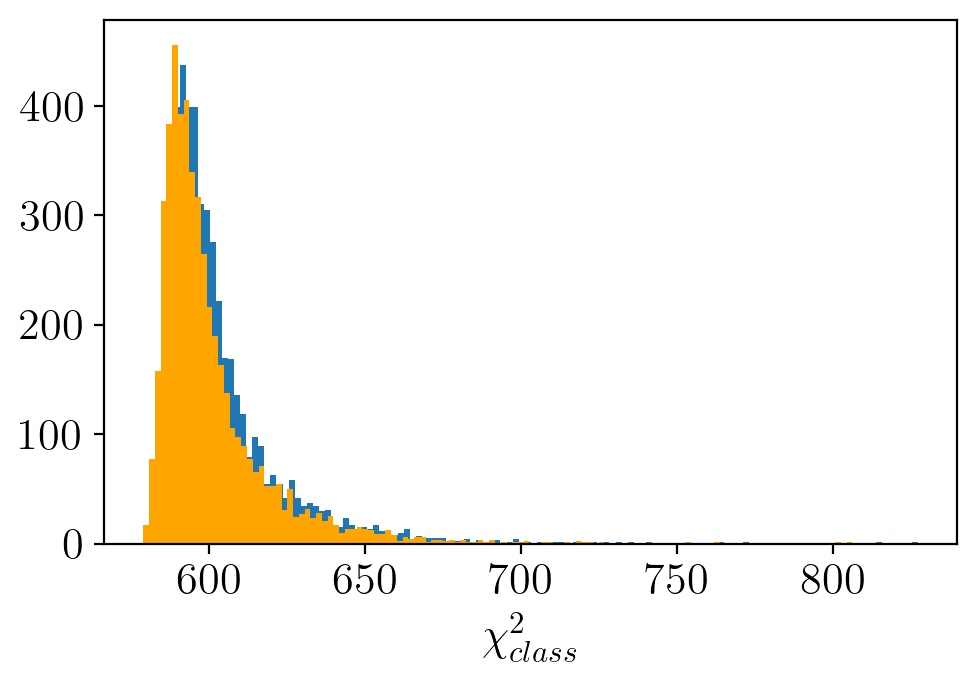

In [223]:
fig,ax = plt.subplots()
fig.set_size_inches(w=5.5, h=3.4)

#ax.plot(em.ell, predictions["tt"][0])
i=3
print(Delta_chi2[i])
high_ell = ell[28:]
print(high_ell)
#ax.plot(high_ell, CubicSpline(em.ell, errors["ee"][i])(high_ell))
print(np.sort(chi2_class))
print(np.sort(chi2_emulated))

ax.hist(chi2_class, bins="fd")
ax.hist(chi2_emulated, bins="fd", color="orange")
ax.set_xlabel("$\chi^2_{class}$")
plt.show()
#ax.set_yscale("log")

[-2.97538261 -3.65986563 -3.8878399  ... -6.02762784 -2.02789217
 -0.89076074]


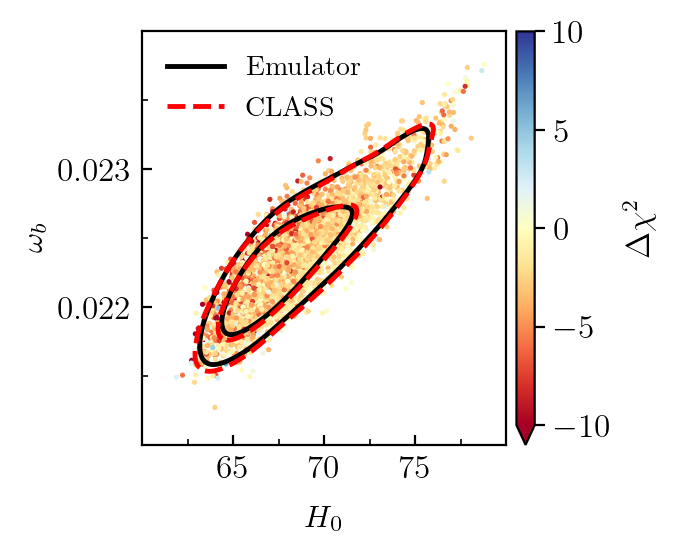

In [242]:
g = plots.get_subplot_plotter()
g.settings = default_settings
#g.settings.fig_width_inch = 3.404
g.settings.fig_width_inch = 3.05
g.settings.legend_frame = False
g.settings.legend_fontsize=11

p1 = "H0"
p2 = "omega_b"

g.plot_2d([chains["modrec_new"], chains["modrec_new_class"]], param1=p1, param2=p2, colors=["black", "red"], ls=["solid", "dashed"])
#g.add_legend(["Emulator", "CLASS"], legend_loc='upper left', figure=True, legend_ncol=2, columnspacing=1, frameon=False)
g.add_legend(["Emulator", "CLASS"], legend_loc="upper left")

ax = g.get_axes()
fig = ax.get_figure()
#with open(em.path + '/test_data.pkl', 'rb') as f:
#    test_data = pkl.load(f)

#model_params = test_data[0]

#test_models =  {
#    "omega_b": model_params[:,0],
#    "omega_cdm": model_params[:,1],
#    "n_s": model_params[:,2],
#    "tau_reio": model_params[:,3],
#    "ln10^{10}A_s": model_params[:,4],
#    "H0": model_params[:,5], 
#    "q_1": model_params[:,6],
#    "q_2": model_params[:,7],
#    "q_3": model_params[:,8],
#    "q_4": model_params[:,9],
#    "q_5": model_params[:,10]
#}

mask = chi2_class>0
print(Delta_chi2[mask])
#norm = mpl.colors.LogNorm(vmin=np.min(avg_tt_error), vmax=np.max(avg_tt_error))
norm = mpl.colors.Normalize(vmin=-10, vmax=10)
#norm = mpl.colors.SymLogNorm(linthresh=250, linscale=3, vmin=np.min(Delta_chi2[mask]), vmax=-np.min(Delta_chi2[mask]))

cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('RdYlBu'))
cmap.set_array([])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

color_arr = np.array(cmap.to_rgba(Delta_chi2))
ax.scatter(test_models[p1][mask], test_models[p2][mask], marker=".", s=3, c=color_arr[mask], zorder=0)

ax.tick_params(axis = 'x', which = 'major', direction="in", labelsize = 12)
ax.tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)
ax.tick_params(axis = 'y', which = 'major', direction="in", labelsize = 12)
ax.tick_params(axis = 'y', which = 'minor', direction="in", labelsize = 0)

ax.set_xlim([ 60, 80 ]) 
ax.set_xticks([65, 70, 75])
ax.set_xticks([62.5, 67.5, 72.5, 77.5], minor=True)

ax.set_ylim([0.021, 0.024])
ax.set_yticks([0.022, 0.023])
ax.set_yticks([0.0215, 0.0225, 0.0235], minor=True)

#ax.set_ylim([ np.min(test_models[p2]), np.max(test_models[p2]) ])

cb = plt.colorbar(cmap, cax=cax, extend="min")
cb.set_label(label="$\Delta \chi^2$",size=12)
cb.ax.tick_params(labelsize=12)
plt.savefig('../results/reweight_contour_with_sample_set.pdf', dpi=300, bbox_inches="tight", pad_inches=0)
#plt.show()

## 1D plots

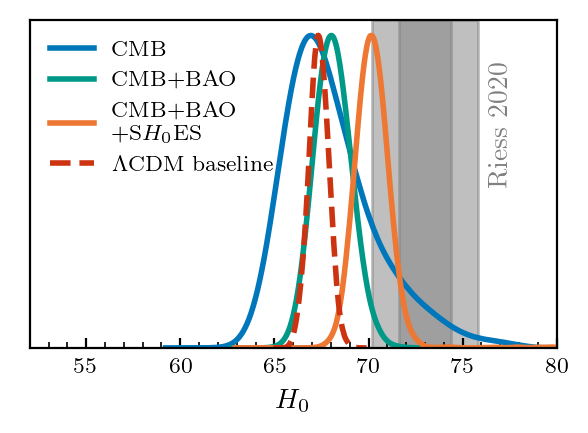

In [202]:
H0_density_cmb = chains["modrec_new_lensing"].get1DDensity("H0")
H0_density_cmb_bao = chains["modrec_new_lensing_bao"].get1DDensity("H0")
H0_density_cmb_bao_shoes = chains["modrec_new_lensing_bao_shoes"].get1DDensity("H0")
H0_density_lcdm = chains["planck_baseline"].get1DDensity("H0")

vibrant_colors = ["#0077BB", "#009988", "#EE7733", "#CC3311"]


fig,ax = plt.subplots()
fig.set_size_inches(w=3.4, h=2.13)


ax.axvspan(73-2*1.4, 73+2*1.4, color="gray", alpha=0.5)
ax.axvspan(73-1*1.4, 73+1*1.4, color="gray", alpha=0.5)

ax.plot(H0_density_cmb.x, H0_density_cmb.P, color=vibrant_colors[0], linewidth=2, linestyle="solid", label="CMB")
ax.plot(H0_density_cmb_bao.x, H0_density_cmb_bao.P, color=vibrant_colors[1], linewidth=2, linestyle="solid", label="CMB+BAO")
ax.plot(H0_density_cmb_bao_shoes.x, H0_density_cmb_bao_shoes.P, color=vibrant_colors[2], linewidth=2, linestyle="solid", label="CMB+BAO\n+S$H_0$ES")
ax.plot(H0_density_lcdm.x, H0_density_lcdm.P, color=vibrant_colors[3], linewidth=2, linestyle="dashed", label="$\Lambda$CDM baseline")

ax.text(0.87, 0.5, "Riess 2020", rotation=90, transform=ax.transAxes, color="gray")

ax.tick_params(axis = 'x', which = 'major', direction="in", labelsize = 8)
ax.tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)

major_tick_loc = [55,60,65,70,75,80]
ax.set_xticks(major_tick_loc, major=True)
ax.set_xticks([i for i in np.arange(50, 81) if i not in major_tick_loc], minor=True)

ax.set_yticks([])
ax.set_xlabel("$H_0$")
ax.set_xlim([52, 80])
ax.legend(frameon=False, fontsize=8, loc="upper left")
ax.set_ylim([0.00,1.05])
plt.savefig('../results/H0_marginalized_posteriors.pdf', dpi=300, bbox_inches="tight")


In [185]:
exclude = [55,60,65,70,75,80]
[i for i in np.arange(50, 81) if i not in exclude]

[50,
 51,
 52,
 53,
 54,
 56,
 57,
 58,
 59,
 61,
 62,
 63,
 64,
 66,
 67,
 68,
 69,
 71,
 72,
 73,
 74,
 76,
 77,
 78,
 79]

## Color coded $H_0$ plots

In [171]:
cmb_only_H0_limit = chains["modrec_new_lensing"].getMargeStats().parWithName("H0").limits[1]
cmb_BAO_H0_limit = chains["modrec_new_lensing_bao"].getMargeStats().parWithName("H0").limits[1]

print(cmb_BAO_H0_limit)

66.2001 70.1549 two


In [43]:
#chain_name = "modrec_new_lensing"

band_left_edges = np.arange(63.5, 73.5, 1)

chains_to_plot = ["modrec_new_lensing", "modrec_new_lensing_bao"]

pred_dict = {}
model_dict = {}
for chain_name in chains_to_plot:
    pred_dict[chain_name] = {}
    model_dict[chain_name] = {}
    for band in band_left_edges:
        selection_criteria = {"H0": [band, band+1],
                            "chi2": [0, chi2_lensing_bao_lcdm_bestfit]}
        selection_predictions, selection_models =  get_predictions_for_selection(chains[chain_name], em, criteria=selection_criteria)
        pred_dict[chain_name][band] = selection_predictions
        model_dict[chain_name][band] = selection_models

(chain_as_dict["H0"] > 63.5) & (chain_as_dict["H0"] < 64.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 64.5) & (chain_as_dict["H0"] < 65.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 65.5) & (chain_as_dict["H0"] < 66.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 66.5) & (chain_as_dict["H0"] < 67.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 67.5) & (chain_as_dict["H0"] < 68.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 68.5) & (chain_as_dict["H0"] < 69.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 69.5) & (chain_as_dict["H0"] < 70.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 70.5) & (chain_as_dict["H0"] < 71.5) & (chain_

In [44]:
for band in band_left_edges:
    print("{}\t{}\t{}".format(band+0.5,len(model_dict[chains_to_plot[0]][band]["H0"]), len(model_dict[chains_to_plot[1]][band]["H0"]) ))

64.0	279	0
65.0	3283	0
66.0	10038	0
67.0	14923	70
68.0	13265	1164
69.0	9215	628
70.0	5489	3
71.0	3286	0
72.0	1917	0
73.0	1223	0


63.5
64.5
65.5
66.5
67.5
68.5
69.5
70.5
71.5
72.5


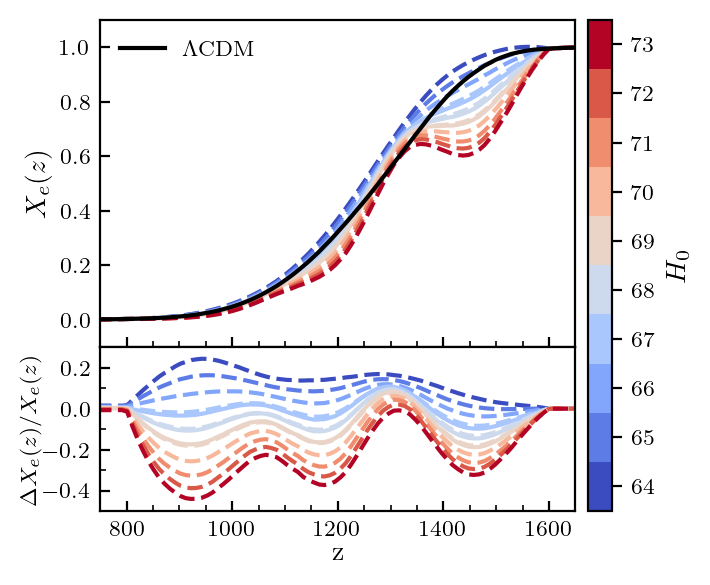

In [150]:
fig = plt.figure()
fig.set_size_inches(w=3.3, h=3.19)

quantity = "x_e"

grid = plt.GridSpec(2, 2, width_ratios=[1, .05], height_ratios=[1,.5], hspace=0.0, wspace=0.05)
main_ax = fig.add_subplot(grid[:-1, 0])
err_ax = fig.add_subplot(grid[-1, 0], sharex=main_ax)
cax = fig.add_subplot(grid[:, 1])

z_grid = em.output_info["output_z_grids"][quantity]

#####################################
# Colorbar settings
#####################################

norm = mpl.colors.Normalize(vmin=band_left_edges[0], vmax=band_left_edges[-1])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('coolwarm'))
cmap.set_array([])

list_of_colors = []
for edge in band_left_edges:
    list_of_colors.append(cmap.to_rgba(edge))

boundaries = np.hstack([band_left_edges, band_left_edges[-1]+1])
norm = mpl.colors.BoundaryNorm(boundaries, ncolors = len(band_left_edges))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.colors.ListedColormap(list_of_colors))

ms = chains["modrec_new_lensing"].getMargeStats()
i=0
for H0_band, d in pred_dict["modrec_new_lensing"].items():
    
    mean_quant_cmb_only = np.mean(d[quantity], axis=0)
    mean_frac_cmb_only = np.mean((d[quantity]-planck_predictions_bestfit[quantity][0])/planck_predictions_bestfit[quantity][0], axis=0)

    print(H0_band)
    if (((H0_band+0.5) > cmb_only_H0_limit.lower) and ((H0_band+0.5) < cmb_only_H0_limit.upper) and (len(d[quantity]) > 50)):
        main_ax.plot(z_grid, mean_quant_cmb_only, color=cmap.to_rgba(H0_band), linestyle="dashed")
        err_ax.plot(z_grid, mean_frac_cmb_only, color=cmap.to_rgba(H0_band), linestyle="dashed")
    
    mean_quant_cmb_bao = np.mean(pred_dict["modrec_new_lensing_bao"][H0_band][quantity], axis=0)
    mean_frac_cmb_bao = np.mean((pred_dict["modrec_new_lensing_bao"][H0_band][quantity]-planck_predictions_bestfit[quantity][0])/planck_predictions_bestfit[quantity][0], axis=0)

    if (((H0_band+0.5) > cmb_BAO_H0_limit.lower) and ((H0_band+0.5) < cmb_BAO_H0_limit.upper) and (len(pred_dict["modrec_new_lensing_bao"][H0_band][quantity]) > 50)):
        main_ax.plot(z_grid, mean_quant_cmb_bao, color=cmap.to_rgba(H0_band))
        err_ax.plot(z_grid, mean_frac_cmb_bao, color=cmap.to_rgba(H0_band))
    i+=1

main_ax.plot(z_grid, planck_predictions_bestfit[quantity][0], color="black", label="$\Lambda$CDM")

for ax in [main_ax, err_ax]:

    ax.set_xlim([750, 1650])

    ax.tick_params(axis = 'x', which = 'major', direction="in", labelsize = 8)
    ax.tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)
    ax.tick_params(axis = 'y', which = 'major', direction="in", labelsize = 8)
    ax.tick_params(axis = 'y', which = 'minor', direction="in", labelsize = 0)

    #ax.set_yticks([.25, .75], minor=True)

    #ax.legend(frameon=False, fontsize=10, loc="upper left", )

main_ax.set_xticks([800, 1000, 1200, 1400, 1600], major=True)
main_ax.set_xticks([850, 900, 950, 1050, 1100, 1150, 1250, 1300, 1350, 1450, 1500, 1550], minor=True)
main_ax.set_ylim([-0.1, 1.1])
main_ax.set_ylabel("$X_e(z)$", fontsize=10, labelpad=3)
main_ax.legend(frameon=False, fontsize = 8, loc="upper left")


err_ax.set_yticks([-0.4, -0.2, 0.0, 0.2], major=True)
err_ax.set_yticks([-0.5, -0.3, -0.1, 0.1], minor=True)
err_ax.set_ylim([-0.5, 0.3])
err_ax.set_ylabel("$\Delta X_e(z) / X_e(z)$", fontsize=8, labelpad=0)
err_ax.set_xlabel("z", fontsize=10, labelpad=0)

cb_ticks = band_left_edges[::1]+0.5
cb = plt.colorbar(cmap, cax=cax, ticks=cb_ticks)
cb.ax.tick_params(labelsize=8, which="major")
cb.ax.tick_params(size=0, which="minor")
cb.set_label(label="$H_0$",size=10)
#plt.savefig('../results/xe_colorcoded_H0.pdf', dpi=300, bbox_inches="tight" )

### visibility function

In [112]:
def get_max_and_fwhm(zgrid, visibility):
    viz_function = CubicSpline(zgrid, visibility)
    z_max = scipy.optimize.fmin(lambda z: -viz_function(z), 1080, disp=False)
    g_max = viz_function(z_max)
    lower = scipy.optimize.root_scalar(lambda z: viz_function(z)-g_max/2, bracket=[z_grid[0], z_max]).root
    upper = scipy.optimize.root_scalar(lambda z: viz_function(z)-g_max/2, bracket=[z_max, z_grid[-1]]).root

    return z_max[0], np.vstack([z_max-lower, upper-z_max])

63.5
64.5
65.5
66.5
67.5
68.5
69.5
70.5
71.5
72.5


/Users/gabe/opt/miniforge3/envs/connect_x86/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gabe/opt/miniforge3/envs/connect_x86/lib/python3.9/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


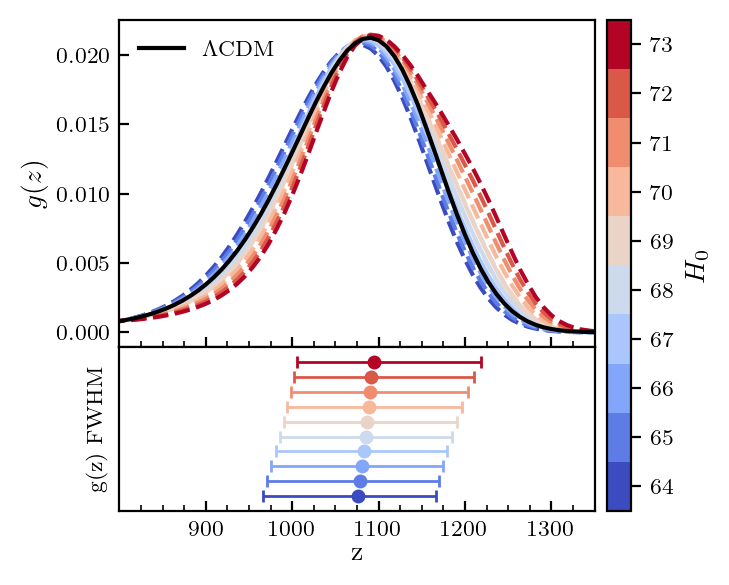

In [149]:
fig = plt.figure()
fig.set_size_inches(w=3.3, h=3.19)

quantity = "g"

grid = plt.GridSpec(2, 2, width_ratios=[1, .05], height_ratios=[1,.5], hspace=0.0, wspace=0.05)
main_ax = fig.add_subplot(grid[:-1, 0])
err_ax = fig.add_subplot(grid[-1, 0], sharex=main_ax)
cax = fig.add_subplot(grid[:, 1])

z_grid = em.output_info["output_z_grids"][quantity]
yspace = np.arange(1,len(band_left_edges)+1)


#####################################
# Colorbar settings
#####################################

norm = mpl.colors.Normalize(vmin=band_left_edges[0], vmax=band_left_edges[-1])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('coolwarm'))
cmap.set_array([])

list_of_colors = []
for edge in band_left_edges:
    list_of_colors.append(cmap.to_rgba(edge))

boundaries = np.hstack([band_left_edges, band_left_edges[-1]+1])
norm = mpl.colors.BoundaryNorm(boundaries, ncolors = len(band_left_edges))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.colors.ListedColormap(list_of_colors))

i=0
for H0_band, d in pred_dict["modrec_new_lensing"].items():
    mean_quant_cmb_only = np.mean(d[quantity], axis=0)

    print(H0_band)
    
    if (((H0_band+0.5) > cmb_only_H0_limit.lower) and ((H0_band+0.5) < cmb_only_H0_limit.upper) and (len(d[quantity]) > 50)):
        zmax, width = get_max_and_fwhm(z_grid, mean_quant_cmb_only)
        main_ax.plot(z_grid, mean_quant_cmb_only, color=cmap.to_rgba(H0_band), linestyle="dashed")
        err_ax.errorbar(zmax, yspace[i], xerr=width, ecolor=cmap.to_rgba(H0_band), elinewidth=1, marker="o", mfc=cmap.to_rgba(H0_band),
                mec=cmap.to_rgba(H0_band), ms=4, mew=1, capsize=2)

    mean_quant_cmb_bao = np.mean(pred_dict["modrec_new_lensing_bao"][H0_band][quantity], axis=0)

    if (((H0_band+0.5) > cmb_BAO_H0_limit.lower) and ((H0_band+0.5) < cmb_BAO_H0_limit.upper) and (len(pred_dict["modrec_new_lensing_bao"][H0_band][quantity]) > 50)):
        zmax, width = get_max_and_fwhm(z_grid, mean_quant_cmb_bao)
        main_ax.plot(z_grid, mean_quant_cmb_bao, color=cmap.to_rgba(H0_band))
    i+=1


main_ax.plot(z_grid, planck_predictions_bestfit[quantity][0], color="black", label="$\Lambda$CDM")

for ax in [main_ax, err_ax]:

    ax.set_xlim([800, 1350])

    ax.tick_params(axis = 'x', which = 'major', direction="in", labelsize = 8)
    ax.tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)
    ax.tick_params(axis = 'y', which = 'major', direction="in", labelsize = 8)
    ax.tick_params(axis = 'y', which = 'minor', direction="in", labelsize = 0)


main_ax.set_xticks([900, 1000, 1100, 1200, 1300], major=True)
main_ax.set_xticks([825, 850, 875, 925, 950, 975, 1025, 1050, 1075, 1125, 1150, 1175, 1225, 1250, 1275, 1325, 1350], minor=True)
main_ax.set_ylabel("$g(z)$", fontsize=10, labelpad=3)
main_ax.legend(frameon=False, fontsize = 8, loc="upper left")

err_ax.set_ylim([0,len(band_left_edges)+1])
err_ax.set_yticks([], major=True)
err_ax.set_ylabel("g(z) FWHM", fontsize=8, labelpad=4)
err_ax.set_xlabel("z", fontsize=10, labelpad=0)

cb_ticks = band_left_edges[::1]+0.5
cb = plt.colorbar(cmap, cax=cax, ticks=cb_ticks)
cb.ax.tick_params(labelsize=8, which="major")
cb.ax.tick_params(size=0, which="minor")
cb.set_label(label="$H_0$",size=10)
#plt.savefig('../results/g_colorcoded_H0.pdf', dpi=300, bbox_inches="tight" )

## With SHOES data

In [ ]:
cmb_only_H0_limit = chains["modrec_new_lensing_bao"].getMargeStats().parWithName("H0").limits[1]


## $\Omega_m$ plots

In [154]:
band_left_edges = np.arange(63.5, 75.5, 1)

chains_to_plot = ["modrec_new_lensing", "modrec_new_lensing_bao"]

pred_dict = {}
model_dict = {}
for chain_name in chains_to_plot:
    pred_dict[chain_name] = {}
    model_dict[chain_name] = {}
    for band in band_left_edges:
        selection_criteria = {"H0": [band, band+1],
                            "chi2": [0, chi2_lensing_bao_lcdm_bestfit]}
        selection_predictions, selection_models =  get_predictions_for_selection(chains[chain_name], em, criteria=selection_criteria)
        pred_dict[chain_name][band] = selection_predictions
        model_dict[chain_name][band] = selection_models

(chain_as_dict["H0"] > 63.5) & (chain_as_dict["H0"] < 64.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 64.5) & (chain_as_dict["H0"] < 65.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 65.5) & (chain_as_dict["H0"] < 66.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 66.5) & (chain_as_dict["H0"] < 67.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 67.5) & (chain_as_dict["H0"] < 68.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 68.5) & (chain_as_dict["H0"] < 69.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 69.5) & (chain_as_dict["H0"] < 70.5) & (chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
(chain_as_dict["H0"] > 70.5) & (chain_as_dict["H0"] < 71.5) & (chain_

[0.14171212 0.14171212 0.14138184 ... 0.14824675 0.14851799 0.14848514]


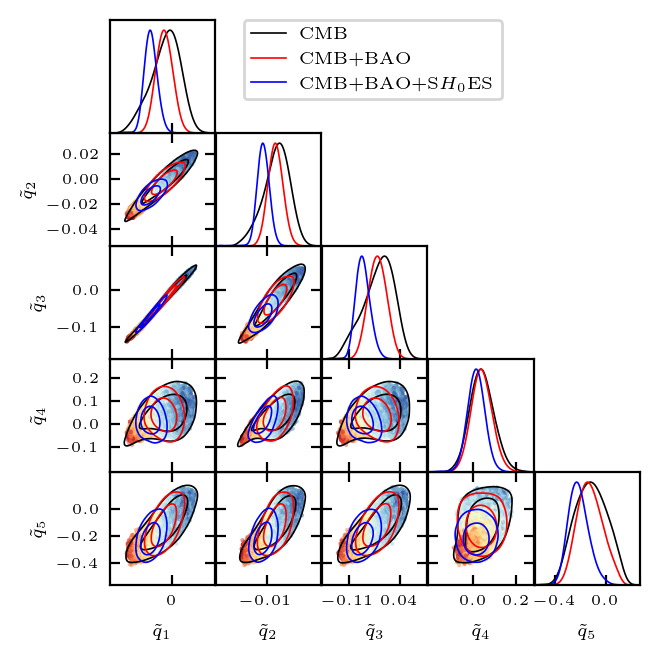

In [200]:
vibrant_colors = ["#0077BB", "#009988", "#EE7733", "#CC3311"]

g = plots.get_subplot_plotter()
g.settings = default_settings
g.settings.fig_width_inch = 3.4

g.settings.solid_colors = vibrant_colors

labels = ["CMB", "CMB+BAO",  "CMB+BAO+S$H_0$ES", "$\Lambda$CDM Baseline"]


#params_to_plot = ['omega_b', 'omega_cdm', "logA", "n_s", "tau_reio", "H0"]
params_to_plot = ["qt_1","qt_2","qt_3","qt_4","qt_5"]
#params_to_plot = ['rs_star', 'rs_d']

lw = 2
g.triangle_plot([chains["modrec_new_lensing"], chains["modrec_new_lensing_bao"], chains["modrec_new_lensing_bao_shoes"]], legend_labels=labels, params=params_to_plot, filled=False)
#g.plot_2d([chains["modrec_new_lensing_bao_shoes"]], "rs_d", "H0", filled=True)

#g.add_legend(legend_labels=labels, legend_loc='lower left', fontsize=8)

def get_physical_qi(standard_predictions, input_models, q_index):
    pivots=[933.3333,1066.6667,1200.0000,1333.3333,1466.6667]
    qlist=["q_1", "q_2", "q_3", "q_4", "q_5"]
    outlist = []
    for i in np.arange(len(input_models["H0"])):
        qi = input_models[qlist[q_index]][i]
        YHe = standard_predictions["YHe"][i]
        xe_max = 1 + YHe/2*(1-YHe)
        xe_fid = CubicSpline(em.output_info["output_z_grids"]["x_e"], standard_predictions["x_e"][i])(pivots[q_index])
        #p = fsolve(lambda aa: scipy.special.expit(aa)*xe_max - xe_fid, 0)
        p = scipy.special.logit(xe_fid/xe_max)
        outlist.append(scipy.special.expit(qi+p)*xe_max - xe_fid)
        
    return np.array(outlist)

#ax.get_legend().get_frame().set_linewidth(0.0)
#fig.set_size_inches(w=3.4, h=3.4)

param_combos = list(itertools.combinations(params_to_plot, 2))

omega_m_list = []
for d in model_dict["modrec_new_lensing"].values():
    omega_m_list.append(d["omega_b"]+d["omega_cdm"])
omega_m_list = np.hstack(omega_m_list)

print(omega_m_list)

norm = mpl.colors.Normalize(vmin=np.min(omega_m_list.flatten()), vmax=np.max(omega_m_list.flatten()))
my_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('RdYlBu_r'))


for H0_band, d in model_dict["modrec_new_lensing"].items():
    extension_params = ["q_1", "q_2", "q_3", "q_4", "q_5"]
    if np.array([s.startswith("q") for s in params_to_plot]).any():
        standard_rec_models = d.copy()
        for q in extension_params:
            standard_rec_models[q] = np.zeros(standard_rec_models["H0"].shape)
        standard_rec_predictions = em.get_predictions_dict(standard_rec_models)
        qt_list = []
        for q in extension_params:
            idx = int(q.split("_")[-1]) - 1
            qt_list.append(get_physical_qi(standard_rec_predictions, d, idx))

    omega_m_array = d["omega_b"] + d["omega_cdm"]

    for c in param_combos:
        ax = g.get_axes_for_params(c[0], c[1])
        c0 = c[0]
        c1 = c[1]
        if (c[0]=="logA"):
            c0 = 'ln10^{10}A_s'
            p0 = d[c0]
        if (c[1]=="logA"):
            c1='ln10^{10}A_s'
            p1= d[c1]

        if c[0].startswith("q"):
            idx = int(c[0].split("_")[-1]) - 1
            p0 = qt_list[idx]
        else:
            p0=d[c[0]]
        if c[1].startswith("q"):
            idx = int(c[1].split("_")[-1]) - 1
            p1 = qt_list[idx]
        else:
            p1=d[c[1]]

        ax.scatter(p0, p1, s=1, marker=".", color=my_cmap.to_rgba(omega_m_array), alpha=0.5)

plt.savefig('../results/qti_colorcoded_omegam.png', dpi=300, bbox_inches="tight" )

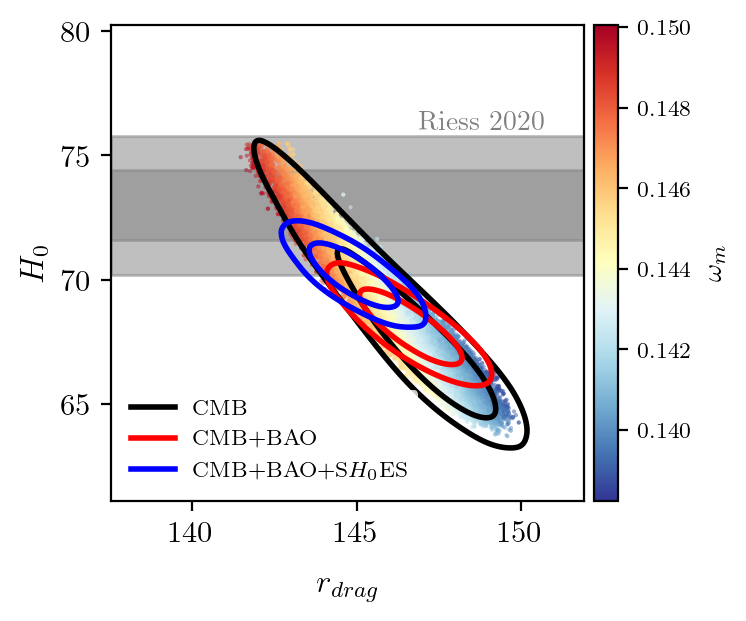

In [201]:
g = plots.get_single_plotter()
g.settings = default_settings
g.settings.fig_width_inch = 1

vibrant_colors = ["#0077BB", "#009988", "#EE7733", "#CC3311"]

g.settings.solid_colors = vibrant_colors

labels = ["CMB", "CMB+BAO",  "CMB+BAO+S$H_0$ES", "$\Lambda$CDM Baseline"]


ax = g.get_axes()
fig = ax.get_figure()

ax.axhspan(73-2*1.4, 73+2*1.4, color="gray", alpha=0.5)
ax.axhspan(73-1*1.4, 73+1*1.4, color="gray", alpha=0.5)

g.plot_2d([chains["modrec_new_lensing"], chains["modrec_new_lensing_bao"], chains["modrec_new_lensing_bao_shoes"]], "rs_d", "H0", lws=[2,2,2])

for H0_band, d in model_dict["modrec_new_lensing"].items():
    omega_m_arr = d["omega_b"] + d["omega_cdm"]
    ax.scatter(pred_dict["modrec_new_lensing"][H0_band]["rs_d"],d["H0"],  s=1, marker=".", color=my_cmap.to_rgba(omega_m_arr), alpha=0.5)

g.add_legend(legend_labels=labels, legend_loc='lower left', fontsize=8)

ax.get_legend().get_frame().set_linewidth(0.0)
fig.set_size_inches(w=2.9, h=2.9)
ax.text(0.65,0.78,s="Riess 2020",transform=ax.transAxes, color="gray", fontsize=10)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cb = plt.colorbar(my_cmap, cax=cax)
cb.set_label(label="$\omega_m$",size=10)
cb.ax.tick_params(labelsize=8)
plt.savefig('../results/H0_rd_plane.png', dpi=300, bbox_inches="tight", pad_inches=0)


## CMB plots

In [41]:
planck_data_tt = np.loadtxt("/Users/gabe/projects/recombination/data/planck/COM_PowerSpect_CMB-TT-binned_R3.01.txt")

planck_tt = {}
planck_tt["Dl_err"] = np.vstack([planck_data_tt[:,2], planck_data_tt[:,3]])
planck_tt["ell"] = planck_data_tt[:,0]
planck_tt["Dl"] = planck_data_tt[:,1]

planck_tt["Cl"] = 2*np.pi/(planck_tt["ell"]*(planck_tt["ell"]+1)) * planck_tt["Dl"]
planck_tt["sigma"] = 2*np.pi/(planck_tt["ell"]*(planck_tt["ell"]+1)) * planck_tt["Dl_err"]

planck_data_te = np.loadtxt("/Users/gabe/projects/recombination/data/planck/COM_PowerSpect_CMB-TE-binned_R3.02.txt")

planck_te = {}
planck_te["Dl_err"] = np.vstack([planck_data_te[:,2], planck_data_te[:,3]])
planck_te["ell"] = planck_data_te[:,0]
planck_te["Dl"] = planck_data_te[:,1]

planck_te["Cl"] = 2*np.pi/(planck_te["ell"]*(planck_te["ell"]+1)) * planck_te["Dl"]
planck_te["sigma"] = 2*np.pi/(planck_te["ell"]*(planck_te["ell"]+1)) * planck_te["Dl_err"]

planck_data_ee = np.loadtxt("/Users/gabe/projects/recombination/data/planck/COM_PowerSpect_CMB-EE-binned_R3.02.txt")

planck_ee = {}
planck_ee["Dl_err"] = np.vstack([planck_data_ee[:,2], planck_data_ee[:,3]])
planck_ee["ell"] = planck_data_ee[:,0]
planck_ee["Dl"] = planck_data_ee[:,1]

planck_ee["Cl"] = 2*np.pi/(planck_ee["ell"]*(planck_ee["ell"]+1)) * planck_ee["Dl"]
planck_ee["sigma"] = 2*np.pi/(planck_ee["ell"]*(planck_ee["ell"]+1)) * planck_ee["Dl_err"]

planck_data = {}
planck_data["tt"] = planck_tt
planck_data["te"] = planck_te
planck_data["ee"] = planck_ee

In [113]:
chain_name = "modrec_new_lensing"
chi2_lcdm = planck_bestfit["chi2_CMB"]

band_left_edges = np.arange(65.5, 75.5, 1)

pred_dict = {}
model_dict = {}
for band in band_left_edges:
    selection_criteria = {"H0": [band, band+1],
                          "chi2__CMB": [0, chi2_lcdm]}
    selection_predictions, selection_models =  get_predictions_for_selection(chains[chain_name], em, criteria=selection_criteria)
    pred_dict[band] = selection_predictions
    model_dict[band] = selection_models

(chain_as_dict["H0"] > 65.5) & (chain_as_dict["H0"] < 66.5) & (chain_as_dict["chi2__CMB"] > 0) & (chain_as_dict["chi2__CMB"] < 2773.099)
(chain_as_dict["H0"] > 66.5) & (chain_as_dict["H0"] < 67.5) & (chain_as_dict["chi2__CMB"] > 0) & (chain_as_dict["chi2__CMB"] < 2773.099)
(chain_as_dict["H0"] > 67.5) & (chain_as_dict["H0"] < 68.5) & (chain_as_dict["chi2__CMB"] > 0) & (chain_as_dict["chi2__CMB"] < 2773.099)
(chain_as_dict["H0"] > 68.5) & (chain_as_dict["H0"] < 69.5) & (chain_as_dict["chi2__CMB"] > 0) & (chain_as_dict["chi2__CMB"] < 2773.099)
(chain_as_dict["H0"] > 69.5) & (chain_as_dict["H0"] < 70.5) & (chain_as_dict["chi2__CMB"] > 0) & (chain_as_dict["chi2__CMB"] < 2773.099)
(chain_as_dict["H0"] > 70.5) & (chain_as_dict["H0"] < 71.5) & (chain_as_dict["chi2__CMB"] > 0) & (chain_as_dict["chi2__CMB"] < 2773.099)
(chain_as_dict["H0"] > 71.5) & (chain_as_dict["H0"] < 72.5) & (chain_as_dict["chi2__CMB"] > 0) & (chain_as_dict["chi2__CMB"] < 2773.099)
(chain_as_dict["H0"] > 72.5) & (chain_as_

In [100]:
with open("/Users/gabe/projects/spt/data/2018_planck_bestfit_spectra.pkl", "rb") as f:
    fid = pkl.load(f)

In [114]:
cl_tt_dict = {}
cl_ee_dict = {}
Tcmb = 2725500.0
muK2 = Tcmb**2
power_spectrum_ells = np.arange(2, 4001)
for band, predictions in pred_dict.items():
    spline = CubicSpline(em.output_info["ell"],  muK2*predictions["tt"], axis=1)(power_spectrum_ells)
    cl_tt_dict[band] = spline
    spline = CubicSpline(em.output_info["ell"], muK2*predictions["ee"], axis=1)(power_spectrum_ells)
    cl_ee_dict[band] =  spline

#ell_factor = power_spectrum_ells*(power_spectrum_ells+1)/(2*np.pi)
#tt_fid = CubicSpline(power_spectrum_ells,ell_factor*fid["tt"])(power_spectrum_ells)
#tt_fid_at_data = CubicSpline(power_spectrum_ells, ell_factor*fid["tt"])(planck_data["tt"]["ell"])
#ee_fid = CubicSpline(power_spectrum_ells, ell_factor*fid["ee"])(power_spectrum_ells)
#ee_fid_at_data = CubicSpline(power_spectrum_ells, ell_factor*fid["ee"])(planck_data["ee"]["ell"])

tt_fid = CubicSpline(em.output_info["ell"], muK2*planck_predictions["tt"][0])(power_spectrum_ells)
tt_fid_at_data = CubicSpline(em.output_info["ell"], muK2*planck_predictions["tt"][0])(planck_data["tt"]["ell"])
ee_fid = CubicSpline(em.output_info["ell"], muK2*planck_predictions["ee"][0])(power_spectrum_ells)
ee_fid_at_data = CubicSpline(em.output_info["ell"], muK2*planck_predictions["ee"][0])(planck_data["ee"]["ell"])

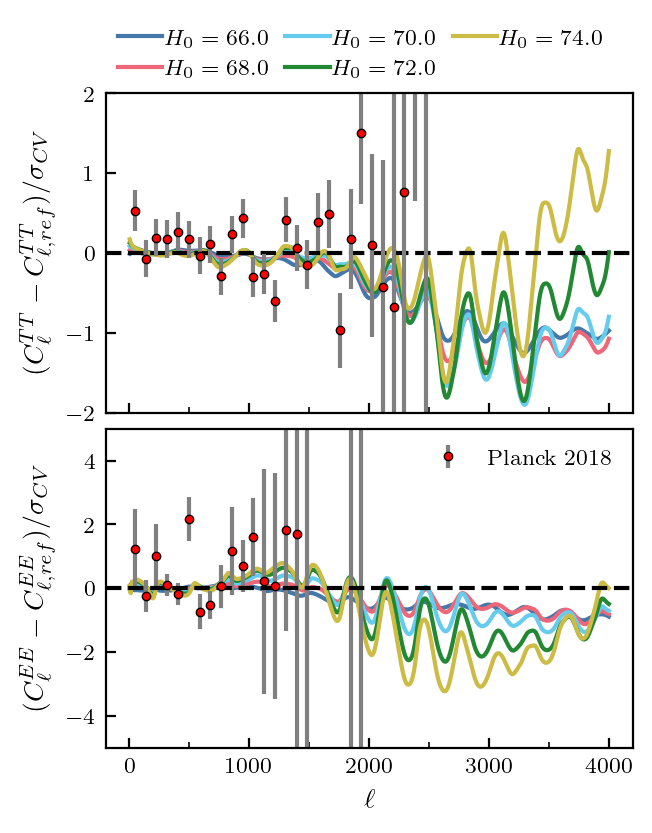

In [115]:
fig,ax = plt.subplots(2,1, sharex=True)
fig.set_size_inches(w=3.4, h=4.25)
fig.subplots_adjust(hspace=0.05)

bands_to_plot = band_left_edges[::2]

bright_colors = ["#4477AA", "#EE6677", "#66CCEE", "#228833", "#CCBB44", "#AA3377", "#BBBBBB"]

color_dict = {}
for i,edge in enumerate(bands_to_plot):
    #color_dict[edge] = cmap.to_rgba(edge)
    color_dict[edge] = bright_colors[i]

for i,band in enumerate(bands_to_plot):
    tt_mean = np.mean(cl_tt_dict[band], axis=0)
    ee_mean = np.mean(cl_ee_dict[band], axis=0)
    ref = np.sqrt((2./(2*power_spectrum_ells+1))*tt_fid**2)
    ax[0].plot(power_spectrum_ells, (tt_mean-tt_fid)/ref, color=color_dict[band], label="$H_0 = {}$".format(band+0.5))
    ref = np.sqrt((2./(2*power_spectrum_ells+1))*ee_fid**2)
    ax[1].plot(power_spectrum_ells, (ee_mean-ee_fid)/ref, color=color_dict[band])

marker_size = 3
cap = 0
skip=3

ax[0].axhline(0.0, color="black", linestyle="dashed")

tt_data_ref = np.sqrt((2./(2*planck_data["tt"]["ell"]+1))*tt_fid_at_data**2)
ax[0].errorbar(x=planck_data["tt"]["ell"][::skip], y=(planck_data["tt"]["Dl"][::skip] - tt_fid_at_data[::skip])/tt_data_ref[::skip], yerr=planck_data["tt"]["Dl_err"][:, ::skip]/tt_data_ref[::skip], ecolor="gray", elinewidth=1.5, marker="o", ls="none", mfc='red',
                mec='black', ms=marker_size, mew=0.5, capsize=cap)

ee_data_ref = np.sqrt((2./(2*planck_data["ee"]["ell"]+1))*ee_fid_at_data**2)
ax[1].errorbar(x=planck_data["ee"]["ell"][::skip], y=(planck_data["ee"]["Dl"][::skip] - ee_fid_at_data[::skip])/ee_data_ref[::skip], yerr=planck_data["ee"]["Dl_err"][:, ::skip]/ee_data_ref[::skip], ecolor="gray", elinewidth=1.5, marker="o", ls="none", mfc='red',
                mec='black', ms=marker_size, mew=0.5, capsize=cap, label="Planck 2018")

ax[0].tick_params(axis = 'x', which = 'major', direction="in", labelsize = 0)
ax[0].tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)
ax[1].tick_params(axis = 'x', which = 'major', direction="in", labelsize = 8)
ax[1].tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)

ax[0].tick_params(axis = 'y', which = 'major', direction="in", labelsize = 8)
ax[0].tick_params(axis = 'y', which = 'minor', direction="in", labelsize = 0)
ax[1].tick_params(axis = 'y', which = 'major', direction="in", labelsize = 8)
ax[1].tick_params(axis = 'y', which = 'minor', direction="in", labelsize = 0)

ax[1].set_xticks([0,1000, 2000, 3000, 4000], major=True)
ax[1].set_xticks([500, 1500, 2500, 3500], minor=True)

ax[1].axhline(0.0, color="black", linestyle="dashed")

ax[0].set_ylim([-2, 2])
ax[1].set_ylim([-5, 5])

ax[0].set_ylabel("$(C_\ell^{TT} - C_{\ell,ref}^{TT}) / \sigma_{CV}$", fontsize=10)
ax[1].set_ylabel("$(C_\ell^{EE} - C_{\ell,ref}^{EE}) / \sigma_{CV}$", fontsize=10)

ax[1].set_xlabel("$\ell$", fontsize=10)

ax[1].legend(frameon=False, fontsize=8, loc="upper right")
handles, labels = ax[0].get_legend_handles_labels()

plt.figlegend(handles,
              labels,
              bbox_to_anchor=(0, 0.78, 1.0, 0.2),
              loc="upper center", 
              ncol=3, 
              columnspacing=0.75,
              handletextpad=0.1,
              fontsize=8,
              frameon=False)

#plt.savefig('../results/Cl_residuals_with_planck.pdf', dpi=300, bbox_inches="tight", pad_inches=0)


## BAO plots

In [139]:
chain_name = "modrec_new_lensing"
chi2_lcdm = planck_bestfit["chi2_CMB"]

band_left_edges = np.arange(65.5, 75.5, 1)

pred_dict = {}
model_dict = {}
for band in band_left_edges:
    selection_criteria = {"H0": [band, band+1]}
    selection_predictions, selection_models =  get_predictions_for_selection(chains[chain_name], em, criteria=selection_criteria)
    pred_dict[band] = selection_predictions
    model_dict[band] = selection_models

(chain_as_dict["H0"] > 65.5) & (chain_as_dict["H0"] < 66.5)
(chain_as_dict["H0"] > 66.5) & (chain_as_dict["H0"] < 67.5)
(chain_as_dict["H0"] > 67.5) & (chain_as_dict["H0"] < 68.5)
(chain_as_dict["H0"] > 68.5) & (chain_as_dict["H0"] < 69.5)
(chain_as_dict["H0"] > 69.5) & (chain_as_dict["H0"] < 70.5)
(chain_as_dict["H0"] > 70.5) & (chain_as_dict["H0"] < 71.5)
(chain_as_dict["H0"] > 71.5) & (chain_as_dict["H0"] < 72.5)
(chain_as_dict["H0"] > 72.5) & (chain_as_dict["H0"] < 73.5)
(chain_as_dict["H0"] > 73.5) & (chain_as_dict["H0"] < 74.5)
(chain_as_dict["H0"] > 74.5) & (chain_as_dict["H0"] < 75.5)


In [247]:
def effective_f_sigma8(predictions, em, z_grid, z_step=0.1):

    sigma8_z_grid = em.output_info["output_z_grids"]["sigma8_z"]
    sigma8_predictions = predictions["sigma8_z"]
    fs8_predictions = []
    for s8z in sigma8_predictions:
        sigma8_z = CubicSpline(sigma8_z_grid, s8z)
        fs8 = []
        for z in z_grid:
            if z >= z_step:
                fs8.append( (sigma8_z(z-z_step)-sigma8_z(z+z_step))/(2.*z_step)*(1+z) )
            else:
                    # if z is between z_step/10 and z_step, reduce z_step to z, and then stick to two-sided derivative
                if (z > z_step/10.):
                    z_step = z
                    fs8.append( (sigma8_z(z-z_step)-sigma8_z(z+z_step))/(2.*z_step)*(1+z) )
                # if z is between 0 and z_step/10, use single-sided derivative with z_step/10
                else:
                    z_step /=10
                    fs8.append( ( sigma8_z(z)-sigma8_z(z+z_step))/z_step*(1+z) )
        fs8_predictions.append(fs8)
    return np.vstack(fs8_predictions)

In [321]:
BAO_plot_grid = np.linspace(.2, 2, 100)
fs8_predictions = {}
for k,pred in pred_dict.items():
    fs8_predictions[k] = effective_f_sigma8(pred, em, BAO_plot_grid)

In [322]:
DA_over_rd_dict = {}
DA_z_grid = em.output_info["output_z_grids"]["angular_distance"]
for band, predictions in pred_dict.items():
    spline = CubicSpline(DA_z_grid, predictions["angular_distance"], axis=1)(BAO_plot_grid)
    DA_band = spline*(1+BAO_plot_grid)
    DA_over_rd = DA_band.T/pred_dict[band]["rs_d"]
    DA_over_rd_dict[band] = DA_over_rd.T

DA_over_rd_planck = CubicSpline(DA_z_grid, planck_predictions["angular_distance"][0])(BAO_plot_grid)*(1+BAO_plot_grid) / planck_predictions["rs_d"][0]

In [325]:
DH_over_rd_dict = {}
H_z_grid = em.output_info["output_z_grids"]["H"]
for band, predictions in pred_dict.items():
    spline = CubicSpline(H_z_grid, 1.0/predictions["H"], axis=1)(BAO_plot_grid)
    DH_over_rd = spline.T/pred_dict[band]["rs_d"]
    DH_over_rd_dict[band] = DH_over_rd.T

DH_over_rd_planck = CubicSpline(H_z_grid, 1.0/planck_predictions["H"][0])(BAO_plot_grid) / planck_predictions["rs_d"][0]

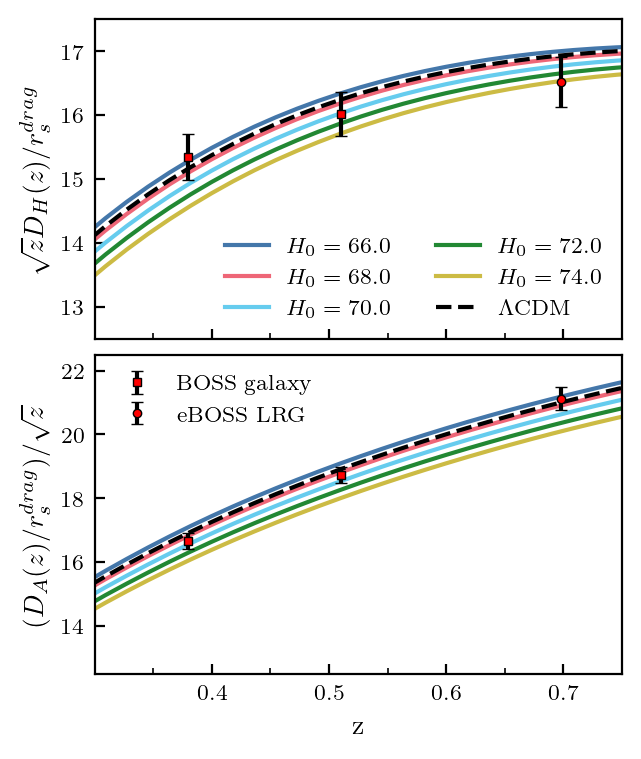

In [360]:
fig,ax = plt.subplots(2,1, sharex=True)
fig.set_size_inches(w=3.4, h=4.25)
fig.subplots_adjust(hspace=0.05)

cMpc = 9.716e-15

bands_to_plot = band_left_edges[::2]
#bands_to_plot = [65.5, 68.5, 70.5, 72.5]


#norm = mpl.colors.Normalize(vmin=bands_to_plot[0], vmax=bands_to_plot[-1])
#cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.rainbow)
#cmap.set_array([])

bright_colors = ["#4477AA", "#EE6677", "#66CCEE", "#228833", "#CCBB44", "#AA3377", "#BBBBBB"]

color_dict = {}
for i,edge in enumerate(bands_to_plot):
    #color_dict[edge] = cmap.to_rgba(edge)
    color_dict[edge] = bright_colors[i]

for i,band in enumerate(bands_to_plot):
    total_num = len(model_dict[band]["omega_b"])

    ax[0].plot(BAO_plot_grid, BAO_plot_grid**(1/2)*np.mean(DH_over_rd_dict[band], axis=0), color=color_dict[band], label="$H_0 = {}$".format(band+0.5))
    #ax[1].plot(fs8_z_grid, np.mean(fs8_predictions[band], axis=0), color=color_dict[band])
    ax[1].plot(BAO_plot_grid, np.mean(DA_over_rd_dict[band], axis=0)/np.sqrt(BAO_plot_grid), color=color_dict[band])
#ax.set_xlim([0,3])

ax[0].plot(BAO_plot_grid, BAO_plot_grid**(1/2)*DH_over_rd_planck, color="black", linestyle="dashed", label="$\Lambda$CDM")
ax[1].plot(BAO_plot_grid, DA_over_rd_planck/np.sqrt(BAO_plot_grid), color="black", linestyle="dashed")


boss_data = {"z": np.array([0.38, 0.51]),
             "DH_over_rd": {"y": np.array([2.489e+01, 2.243e+01]),
                            "yerr": np.sqrt([3.384872999999999910e-01, 2.319183999999999968e-01])} , 
             "DM_over_rd": {"y": np.array([1.027e+01, 1.338e+01]),
                            "yerr": np.sqrt([2.289713999999999985e-02, 3.215813000000000005e-02])},
             "f_sigma8": {"y": np.array([4.974e-01, 4.590e-01]),
                        "yerr":np.sqrt([2.033549999999999854e-03, 1.422890000000000005e-03])}
            }

eboss_data = {"z": np.array([0.698]),
             "DH_over_rd": {"y": np.array([19.769664063200512]),
                            "yerr": np.sqrt([2.200914387195841426e-01])} , 
             "DM_over_rd": {"y": np.array([17.645954975529154]),
                            "yerr": np.sqrt([9.113990099116782428e-02])},
             "f_sigma8": {"y": np.array([0.4730038921505922]),
                          "yerr":np.sqrt([1.961623533477494397e-03])}
            }

marker_size = 3
cap = 2
ax[0].errorbar(x=boss_data["z"], y=np.sqrt(boss_data["z"])*boss_data["DH_over_rd"]["y"], yerr=np.sqrt(boss_data["z"])*boss_data["DH_over_rd"]["yerr"], ecolor="black", elinewidth=1.5, marker="s", ls="none", mfc='red',
                mec='black', ms=marker_size, mew=0.5, capsize=cap)
ax[0].errorbar(x=eboss_data["z"], y=np.sqrt(eboss_data["z"])*eboss_data["DH_over_rd"]["y"], yerr=np.sqrt(eboss_data["z"])*eboss_data["DH_over_rd"]["yerr"], ecolor="black", elinewidth=1.5, marker="o", ls="none", mfc='red',
                mec='black', ms=marker_size, mew=0.5,capsize=cap)

ax[1].errorbar(x=boss_data["z"], y=boss_data["DM_over_rd"]["y"]/np.sqrt(boss_data["z"]), yerr=boss_data["DM_over_rd"]["yerr"]/np.sqrt(boss_data["z"]), ecolor="black", label="BOSS galaxy", elinewidth=1.5, marker="s", ls="none", mfc='red',
                mec='black', ms=marker_size, mew=0.5,capsize=cap)
ax[1].errorbar(x=eboss_data["z"], y=eboss_data["DM_over_rd"]["y"]/np.sqrt(eboss_data["z"]), yerr=eboss_data["DM_over_rd"]["yerr"]/np.sqrt(eboss_data["z"]), ecolor="black", label="eBOSS LRG", elinewidth=1.5, marker="o", ls="none", mfc='red',
                mec='black', ms=marker_size, mew=0.5,capsize=cap)

#ax.set_xscale("log")
ax[0].set_xlim([0.3, 0.75])
ax[0].set_ylim([12.5, 17.5])
ax[1].set_ylim([12.5, 22.5])

ax[0].tick_params(axis = 'x', which = 'major', direction="in", labelsize = 0)
ax[0].tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)
ax[1].tick_params(axis = 'x', which = 'major', direction="in", labelsize = 8)
ax[1].tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)

ax[0].tick_params(axis = 'y', which = 'major', direction="in", labelsize = 8)
ax[0].tick_params(axis = 'y', which = 'minor', direction="in", labelsize = 0)
ax[1].tick_params(axis = 'y', which = 'major', direction="in", labelsize = 8)
ax[1].tick_params(axis = 'y', which = 'minor', direction="in", labelsize = 0)

ax[1].set_xticks([.4, .5, .6, 0.7], major=True)
ax[1].set_xticks([.35, .45, .55, .65], minor=True)

ax[1].set_xlabel("z", fontsize=10)

ax[0].set_ylabel("$\sqrt{z} D_H(z)/r_{s}^{drag} $", fontsize=10)
ax[1].set_ylabel("$(D_A(z)/r_{s}^{drag}) / \sqrt{z}$", fontsize=10)


ax[0].legend(frameon=False, fontsize=8, loc="lower right", ncols=2)
ax[1].legend(frameon=False, fontsize=8, loc="upper left")
plt.savefig('../results/BAO_DH_DA_tensions.pdf', dpi=300, bbox_inches="tight", pad_inches=0)

## Density plots

In [172]:
chain_name = "modrec_new_lensing_bao_shoes"
total_predictions, total_models = get_predictions_for_selection(chains[chain_name], em, criteria='none')

y_range_dict = {"x_e": [0, 1.1],
                "g": [0, 0.025],
                "delta_xe": [-1.1, 1.1],
                "frac_xe": [-0.5, 0.5]}

chain_labels = {"modrec_new": "Primary CMB",
                "modrec_new_lensing": "CMB",
                "modrec_new_lensing_bao": "CMB+BAO",
                "modrec_new_lensing_shoes": "CMB+S$H_0$ES",
                "modrec_new_lensing_bao_shoes": "CMB+BAO+S$H_0$ES"}

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 10,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [173]:
histogram_dict = {}
bin_dict = {}
fine_grid_dict = {}
mean_dict = {}

quantities_to_plot = ["x_e", "g"]

planck_fid_xe = planck_predictions_bestfit["x_e"][0]
planck_fid_g = planck_predictions_bestfit["g"][0]


for quantity in quantities_to_plot:
    selection_predictions, selection_models = get_selection_from_predictions(chains[chain_name], total_predictions, criteria="none")
    trajectories, fine_grid = extract_trajectories_from_predictions(selection_predictions, em, quantity)
    h, bins = construct_trajectory_heatmap(trajectories, y_range=y_range_dict[quantity], num_bins=1000)
    histogram_dict[quantity] = h
    bin_dict[quantity] = bins
    fine_grid_dict[quantity] = fine_grid
    mean_dict[quantity]= np.mean(trajectories, axis=0)
    if quantity=="x_e":
        fid_on_grid = CubicSpline(em.output_info["output_z_grids"]["x_e"], planck_fid_xe)(fine_grid)
        dtraj = trajectories - fid_on_grid
        h,bins = construct_trajectory_heatmap(dtraj, y_range=y_range_dict["delta_xe"], num_bins=1000)
        histogram_dict["delta_xe"]=h
        bin_dict["delta_xe"]=bins
        fine_grid_dict["delta_xe"] = fine_grid
        mean_dict["delta_xe"] = np.mean(dtraj, axis=0)


trajectories, fine_grid = extract_fractional_trajectories(total_predictions, total_models, em, fid_xe=planck_fid_xe)

h, bins = construct_trajectory_heatmap(trajectories, y_range=y_range_dict["frac_xe"], num_bins=1000)

histogram_dict["frac_xe"] = h
bin_dict["frac_xe"] = bins
fine_grid_dict["frac_xe"] = fine_grid
mean_dict["frac_xe"] = np.mean(trajectories, axis=0)


In [35]:
xe_func_fid = CubicSpline(em.output_info["output_z_grids"]["x_e"], planck_predictions_bestfit["x_e"][0])
xe_max_fid = 1 + planck_predictions_bestfit["YHe"][0]/2*(1-planck_predictions_bestfit["YHe"][0])

@np.vectorize
def rescale_pert_amp(q, z, xe_fid, xe_max):
    shift = scipy.special.logit(xe_func_fid(z)/xe_max_fid)
    return scipy.special.expit(q+shift)*xe_max - xe_fid(z)

upper_xe_limit = CubicSpline(em.output_info["output_z_grids"]["x_e"], rescale_pert_amp(100, em.output_info["output_z_grids"]["x_e"], xe_func_fid, xe_max_fid))
lower_xe_limit = CubicSpline(em.output_info["output_z_grids"]["x_e"], rescale_pert_amp(-100, em.output_info["output_z_grids"]["x_e"], xe_func_fid, xe_max_fid))


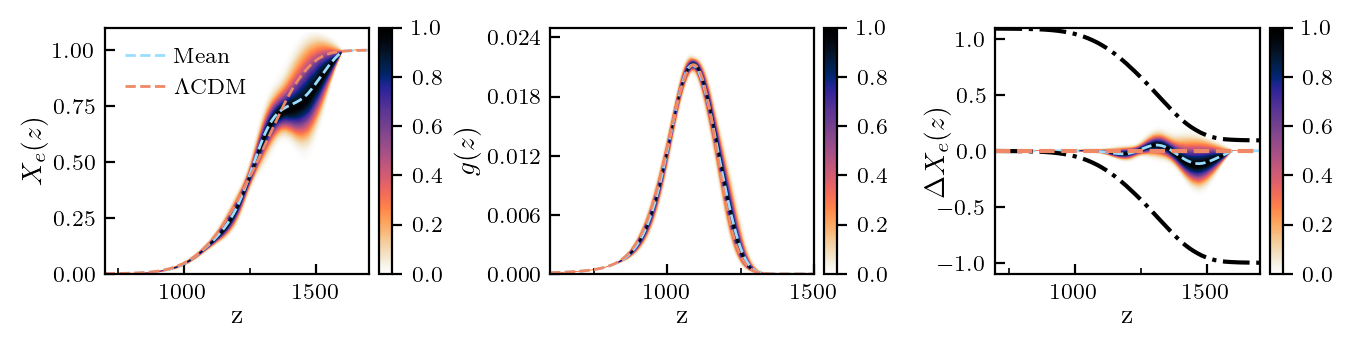

In [36]:
fig,axes = plt.subplots(1,3) 
fig.set_size_inches(w=7.6, h=1.6)
fig.subplots_adjust(wspace=0.55)

mean_color = "#99DDFF"
lcdm_color = "#EE8866"

#########################
# First panel
#########################
quant = "x_e"
ax = axes[0]

m=ax.imshow(histogram_dict[quant], cmap=mpl.cm.get_cmap('cmr.torch_r'), origin="lower", extent=[np.min(fine_grid_dict[quant]), np.max(fine_grid_dict[quant]), np.min(bin_dict[quant]),np.max(bin_dict[quant])], aspect="auto")
ax.plot(fine_grid_dict[quant], mean_dict[quant], color=mean_color, linewidth=1, linestyle="dashed", label="Mean")
ax.plot(fine_grid_dict[quant], CubicSpline(em.output_info["output_z_grids"]["x_e"],planck_fid_xe)(fine_grid_dict[quant]), color=lcdm_color, linewidth=1, linestyle="dashed", label="$\Lambda$CDM")


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])


ax.tick_params(axis = 'x', which = 'major', direction="in", labelsize = 8)
ax.tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)
ax.tick_params(axis = 'y', which = 'major', direction="in", labelsize = 8)
ax.tick_params(axis = 'y', which = 'minor', direction="in", labelsize = 0)

ax.set_xticks([1000, 1500], major=True)
ax.set_xticks([750, 1250], minor=True)

ax.set_xlabel("z", fontsize=10, labelpad=0)
ax.set_ylabel("$X_e(z)$", fontsize=10, labelpad=2)

cb = plt.colorbar(m, cax=cax)
cb.ax.tick_params(labelsize=8)

ax.legend(frameon=False, fontsize=8, loc="upper left", handletextpad=0.2)

#########################
# Second panel
#########################
quant = "g"
ax = axes[1]

m=ax.imshow(histogram_dict[quant], cmap=mpl.cm.get_cmap('cmr.torch_r'), origin="lower", extent=[np.min(fine_grid_dict[quant]), np.max(fine_grid_dict[quant]), np.min(bin_dict[quant]),np.max(bin_dict[quant])], aspect="auto")
ax.plot(fine_grid_dict[quant], mean_dict[quant], color=mean_color, linewidth=1, linestyle="dashed")

ax.plot(fine_grid_dict[quant], CubicSpline(em.output_info["output_z_grids"]["g"],planck_fid_g)(fine_grid_dict[quant]), color=lcdm_color, linewidth=1, linestyle="dashed")



divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])


ax.tick_params(axis = 'x', which = 'major', direction="in", labelsize = 8)
ax.tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)
ax.tick_params(axis = 'y', which = 'major', direction="in", labelsize = 8)
ax.tick_params(axis = 'y', which = 'minor', direction="in", labelsize = 0)

ax.set_xticks([1000, 1500], major=True)
ax.set_xticks([750, 1250], minor=True)

ax.set_yticks([0., .006, .012, .018, .024], major=True)
#ax.set_yticks([.005, .015], minor=True)

ax.set_xlabel("z", fontsize=10, labelpad=0)
ax.set_ylabel("$g(z)$", fontsize=10, labelpad=2)

cb = plt.colorbar(m, cax=cax)
cb.ax.tick_params(labelsize=8)

#########################
# Third panel
#########################
quant = "delta_xe"
ax = axes[2]

m=ax.imshow(histogram_dict[quant], cmap=mpl.cm.get_cmap('cmr.torch_r'), origin="lower", extent=[np.min(fine_grid_dict[quant]), np.max(fine_grid_dict[quant]), np.min(bin_dict[quant]),np.max(bin_dict[quant])], aspect="auto")
ax.plot(fine_grid_dict[quant], mean_dict[quant], color=mean_color, linewidth=1, linestyle="dashed")

ax.plot(fine_grid_dict[quant], upper_xe_limit(fine_grid_dict[quant]), color="black", linestyle="dashdot")
ax.plot(fine_grid_dict[quant], lower_xe_limit(fine_grid_dict[quant]), color="black", linestyle="dashdot")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])


ax.tick_params(axis = 'x', which = 'major', direction="in", labelsize = 8)
ax.tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)
ax.tick_params(axis = 'y', which = 'major', direction="in", labelsize = 8)
ax.tick_params(axis = 'y', which = 'minor', direction="in", labelsize = 0)

ax.set_xticks([1000, 1500], major=True)
ax.set_xticks([750, 1250], minor=True)

ax.axhline(0.0, color=lcdm_color, linestyle="dashed")

ax.set_xlabel("z", fontsize=10, labelpad=0)
ax.set_ylabel("$\Delta X_e(z)$", fontsize=10, labelpad=-5)

cb = plt.colorbar(m, cax=cax)
cb.ax.tick_params(labelsize=8)

#plt.savefig('../results/CMB_BAO_shoes_rec_quantities.pdf', dpi=300, bbox_inches="tight")

## Getting H0 = 70 models

(chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1014.823791899)
69.210066
[1023.8789 1022.6254 1020.9749 ... 1020.0909 1022.4354 1023.345 ]


(array([ 2.,  8., 11., 21., 31., 24., 33., 16.,  4.,  6.]),
 array([67.28672  , 67.4790546, 67.6713892, 67.8637238, 68.0560584,
        68.248393 , 68.4407276, 68.6330622, 68.8253968, 69.0177314,
        69.210066 ]),
 <BarContainer object of 10 artists>)

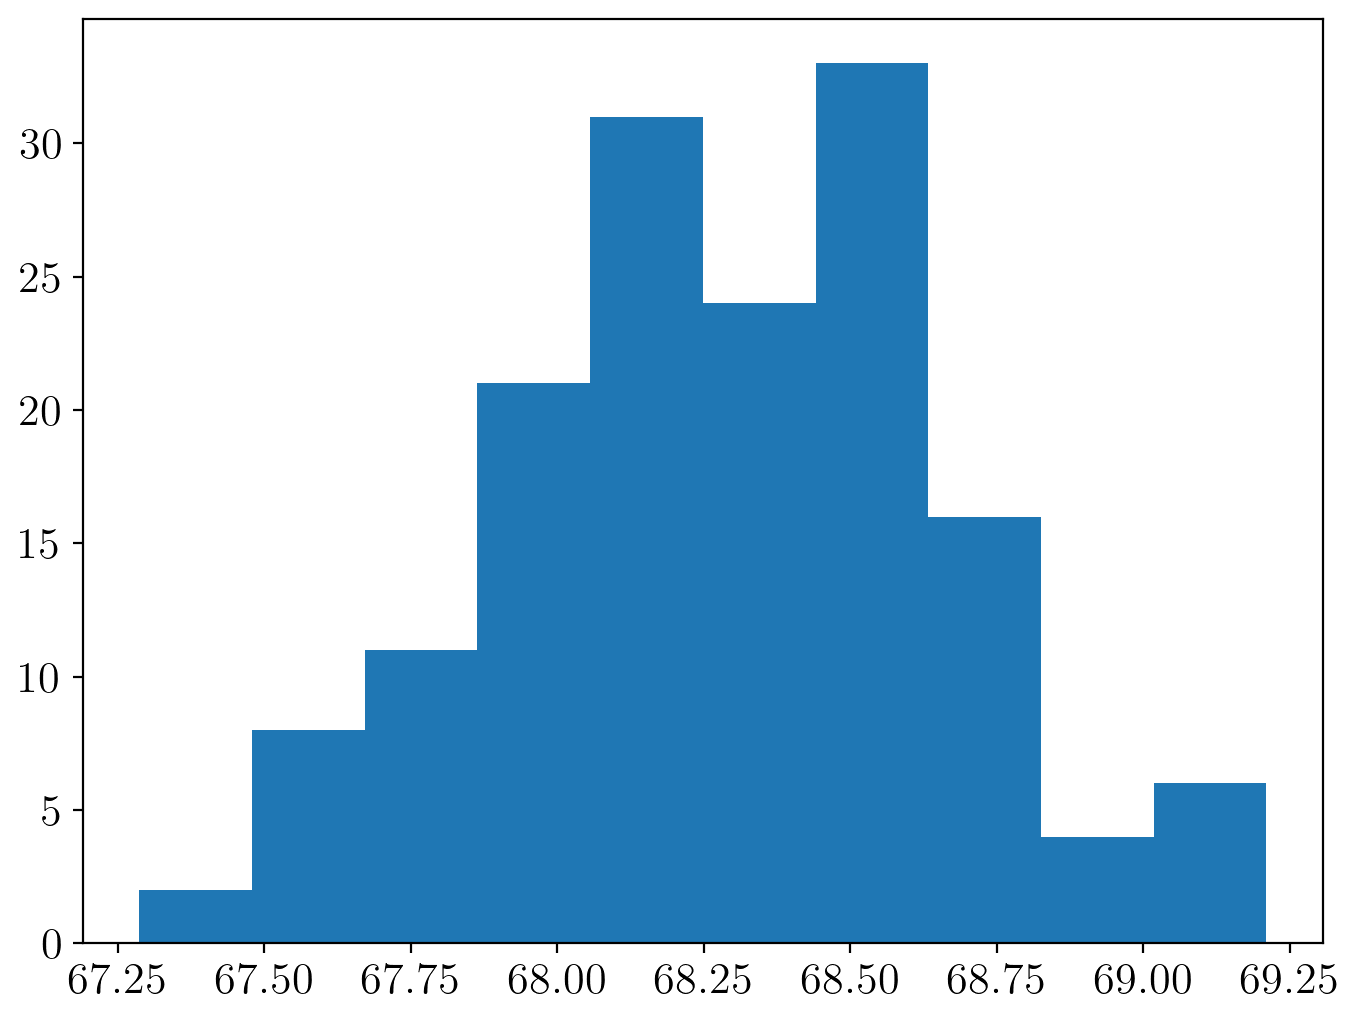

In [165]:
chain_name = "modrec_new_lensing_bao"
chi2_lcdm = planck_bestfit["chi2_CMB"]

selection_criteria = {#"H0": [69.0, 70.0],
                          "chi2": [0, chi2_lensing_bao_lcdm_bestfit-1]}
selection_predictions, selection_models =  get_predictions_for_selection(chains[chain_name], em, criteria=selection_criteria)
print(np.max(selection_models["H0"]) )


print(chains[chain_name].getParams().__dict__["chi2"])

fig,ax = plt.subplots()
ax.hist(selection_models["H0"], bins="fd")

In [149]:
quantity="tt"
trajectories, fine_grid = extract_trajectories_from_predictions(selection_predictions, em, quantity)
best_interp = CubicSpline(em.output_info["ell"], planck_predictions[quantity][0])(fine_grid)
traj = (trajectories-best_interp)/best_interp
y_range = [-.15, 0.15]
h, bins = construct_trajectory_heatmap(traj, y_range=y_range, num_bins=1000)

{'omega_b': 0.022429971, 'omega_cdm': 0.12240417, 'n_s': 0.95953666, 'tau_reio': 0.052884054, 'ln10^{10}A_s': 3.0500962, 'H0': 69.523078, 'q_1': -0.29295538, 'q_2': -0.11192843, 'q_3': -0.2757927, 'q_4': 0.0965496, 'q_5': -1.1479862}


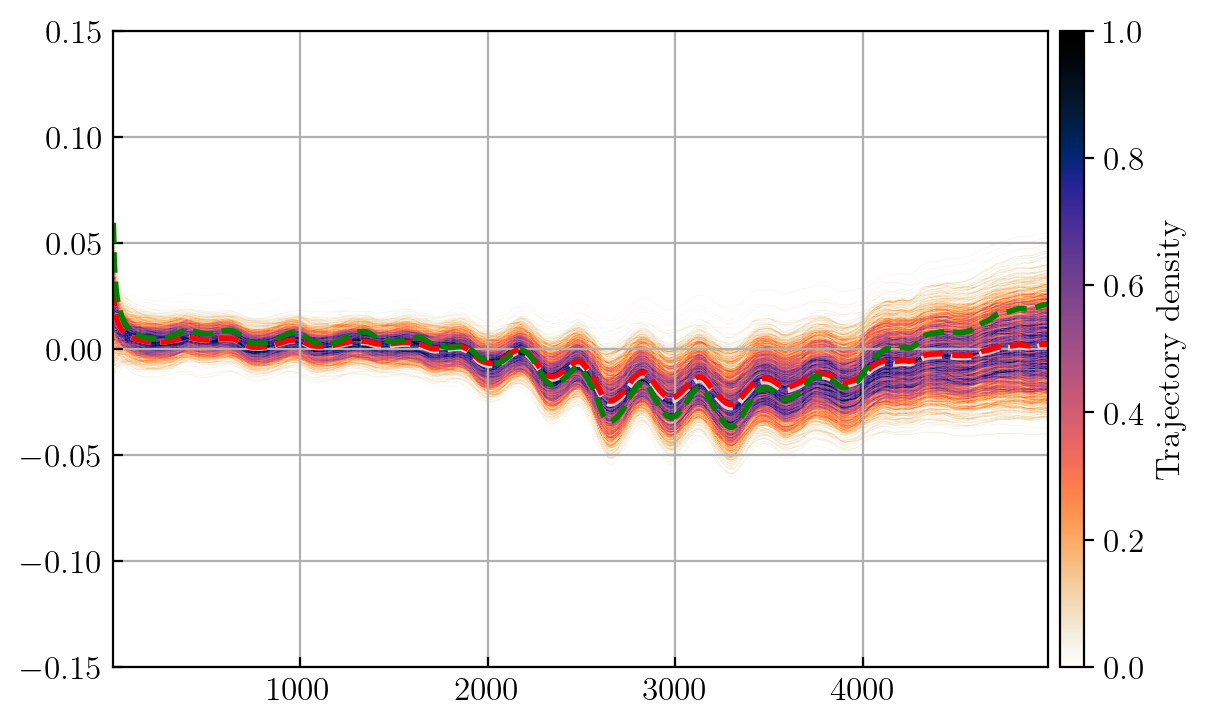

In [150]:
fig,ax = plt.subplots()
fig.set_size_inches(w=6.03, h=4.13)

input_dict = {k:np.mean(selection_models[k]) for k in em.output_info["input_names"]}
emulated_mean = em.get_predictions_dict(input_dict)
emulated_mean = CubicSpline(em.output_info["ell"], emulated_mean[quantity][0])(fine_grid)

input_dict = {k:selection_models[k][1470] for k in em.output_info["input_names"]}
print(input_dict)
emulated_best = em.get_predictions_dict(input_dict)
emulated_best = CubicSpline(em.output_info["ell"], emulated_best[quantity][0])(fine_grid)

m=ax.imshow(h, cmap=mpl.cm.get_cmap('cmr.torch_r'), origin="lower", extent=[np.min(fine_grid), np.max(fine_grid), np.min(bins),np.max(bins)], aspect="auto")
ax.plot(fine_grid,np.mean(traj, axis=0), color="lightgray", linewidth=2, linestyle="dashed")
ax.plot(fine_grid, (emulated_mean-best_interp)/best_interp, color="red", linewidth=2, linestyle="dashed")
ax.plot(fine_grid, (emulated_best-best_interp)/best_interp, color="green", linewidth=2, linestyle="dashed")

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])


ax.tick_params(axis = 'x', which = 'major', direction="in", labelsize = 12)
ax.tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)
ax.tick_params(axis = 'y', which = 'major', direction="in", labelsize = 12)
ax.tick_params(axis = 'y', which = 'minor', direction="in", labelsize = 0)


ax.grid(True)

cb = plt.colorbar(m, cax=cax)
cb.set_label(label="Trajectory density",size=12)
cb.ax.tick_params(labelsize=12)
plt.show()

In [141]:
chain_as_dict = chains[chain_name].getParams().__dict__
selection_criteria = {#"H0": [69.8, 70.2],
                          "chi2": [0, chi2_lensing_bao_lcdm_bestfit]}
criteria = selection_criteria
size_of_total = len(chain_as_dict["H0"])
if criteria=='none':
    idx_of_subsample = np.arange(size_of_total)
elif criteria=='random':
    idx_of_subsample = chain.random_single_samples_indices(max_samples=N)
elif isinstance(criteria, dict):
    criteria_string = ""
    for quantity1, range in criteria.items():
        criteria_string += '(chain_as_dict["{0}"] > {1}) & (chain_as_dict["{2}"] < {3})'.format(quantity1, range[0], quantity1, range[1])
        if quantity1 != list(criteria)[-1]:
            criteria_string += ' & '
    print(criteria_string)
    idx_of_subsample = np.where(eval(criteria_string))

print(len(idx_of_subsample[0]))
print(len(chain_as_dict["H0"][idx_of_subsample]))
arg_of_max_H0 = np.argmax(chain_as_dict["H0"][idx_of_subsample])
print(arg_of_max_H0)
global_arg = idx_of_subsample[0][arg_of_max_H0]

print(global_arg)
print(chi2_lensing_bao_lcdm_bestfit)
print(chain_as_dict["H0"][global_arg])
print(chain_as_dict["chi2"][global_arg])

(chain_as_dict["chi2"] > 0) & (chain_as_dict["chi2"] < 1015.823791899)
1865
1865
1470
602310
1015.823791899
69.523078
1015.4403


In [58]:
print({k:chain_as_dict[k][]})

{'omega_b': 0.02243059, 'omega_cdm': 0.12285155, 'n_s': 0.95754865, 'tau_reio': 0.04936866, 'ln10^{10}A_s': 3.0435158, 'H0': 69.840236, 'q_1': -0.33843761, 'q_2': -0.13268525, 'q_3': -0.31551517, 'q_4': 0.099687452, 'q_5': -1.214831}


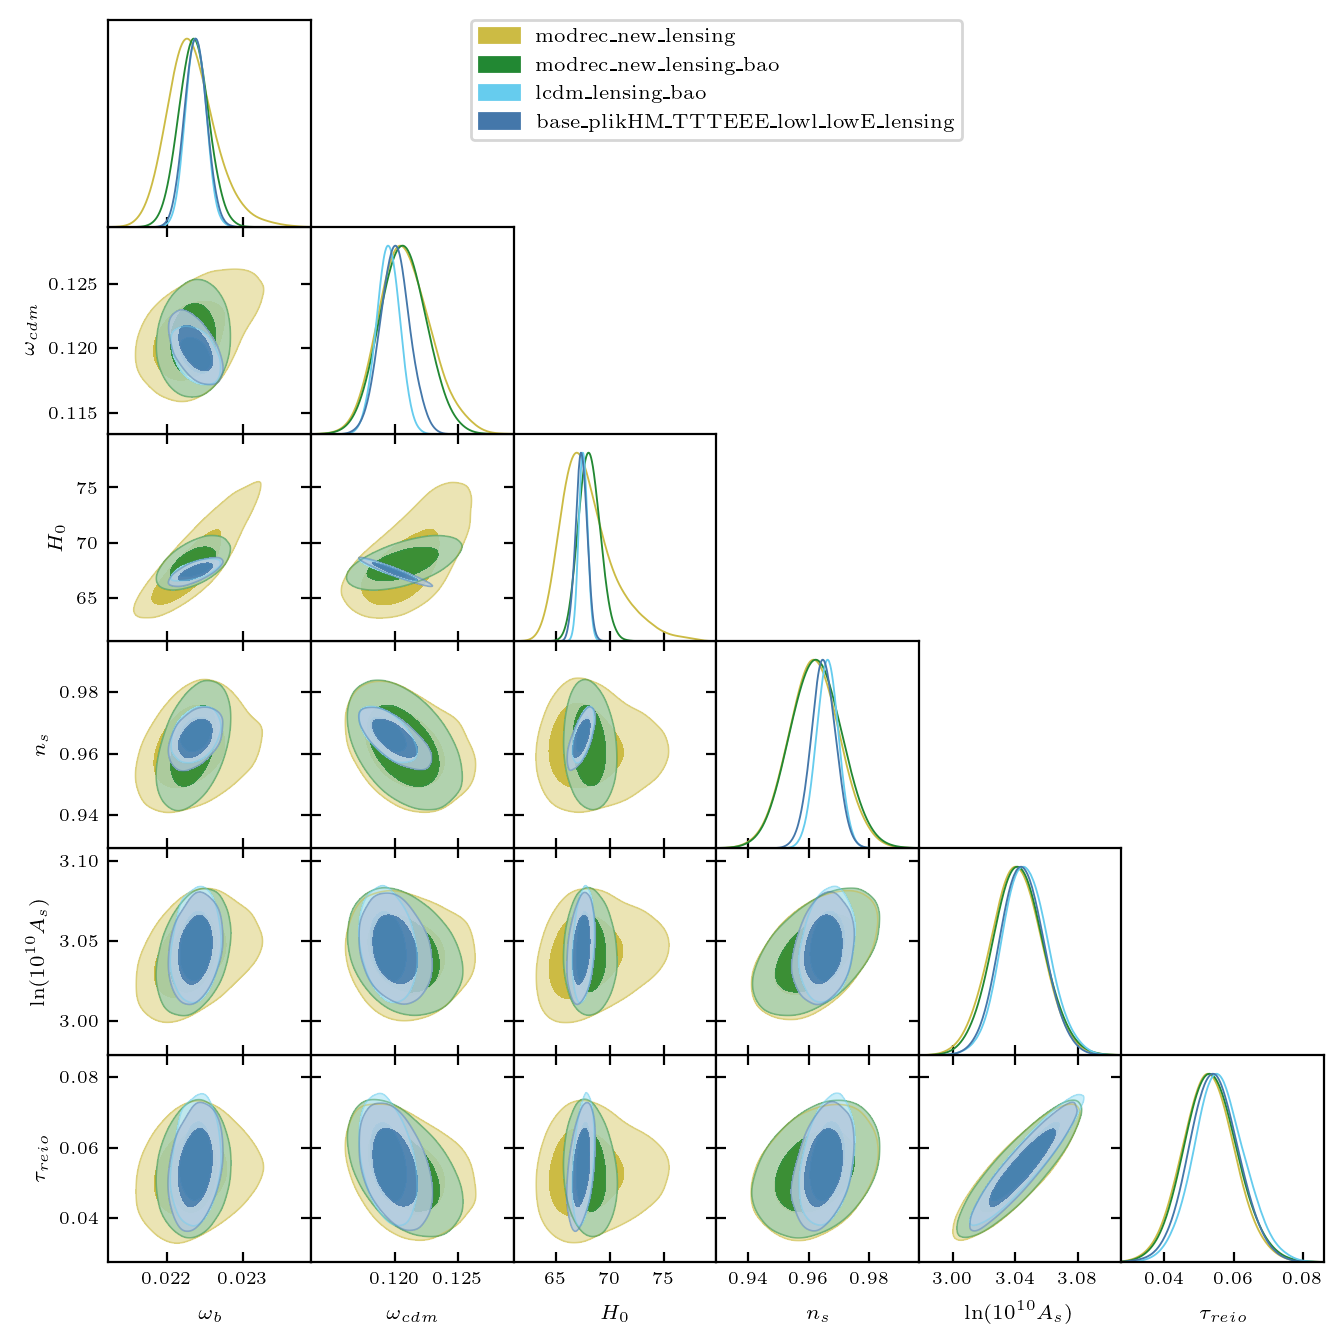

In [73]:
g = plots.get_subplot_plotter()
g.settings = default_settings
g.settings.fig_width_inch = 7

vibrant_colors = ["#0077BB", "#009988", "#EE7733", "#CC3311"]

g.settings.solid_colors = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', "#CC3311"]

labels = ["CMB", "CMB+BAO", "LCDM CMB+BAO", "$\Lambda$CDM Baseline"]


params_to_plot = ['omega_b', 'omega_cdm', 'H0', "n_s", "logA", "tau_reio"]
#params_to_plot = ['rs_star', 'rs_d']

#g.triangle_plot([chains["modrec_new_lensing"], chains["modrec_new_lensing_bao"], chains["modrec_new_lensing_bao_shoes"], chains["planck_baseline"]], legend_labels=labels, params=params_to_plot, filled=True)
g.triangle_plot([chains["modrec_new_lensing"], chains["modrec_new_lensing_bao"],  chains["lcdm_lensing_bao"], chains["planck_baseline"]], params=params_to_plot, filled=True)
#g.plot_2d([chains["modrec_new_lensing_bao_shoes"]], "rs_d", "H0", filled=True)
